# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

In [4]:
data.shape

(23699, 22)

In [5]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


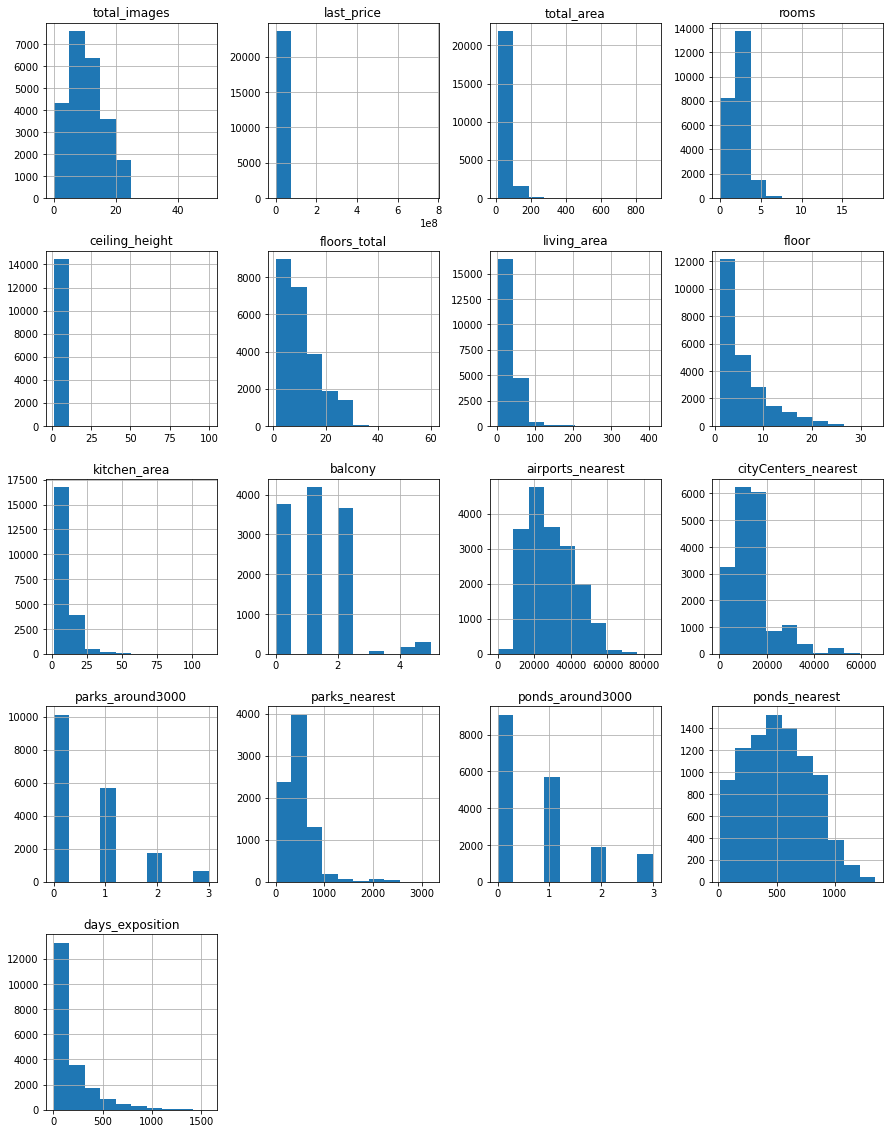

In [6]:
data.hist(figsize=(15, 20));

Взглянем на количество непустых значений и типы столбцов

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

- **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)

- **balcony** — число балконов

- **ceiling_height** — высота потолков (м)

- **cityCenters_nearest** — расстояние до центра города (м)

- **days_exposition** — сколько дней было размещено объявление (от публикации до снятия)

- **first_day_exposition** — дата публикации

- **floor** — этаж

- **floors_total** — всего этажей в доме

- **is_apartment** — апартаменты (булев тип)

- **kitchen_area** — площадь кухни в квадратных метрах (м²)

- **last_price** — цена на момент снятия с публикации

- **living_area** — жилая площадь в квадратных метрах (м²)

- **locality_name** — название населённого пункта

- **open_plan** — свободная планировка (булев тип)

- **parks_around3000** — число парков в радиусе 3 км

- **parks_nearest** — расстояние до ближайшего парка (м)

- **ponds_around3000** — число водоёмов в радиусе 3 км

- **ponds_nearest** — расстояние до ближайшего водоёма (м)

- **rooms** — число комнат

- **studio** — квартира-студия (булев тип)

- **total_area** — общая площадь квартиры в квадратных метрах (м²)

- **total_images** — число фотографий квартиры в объявлении

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [9]:
def pass_value_barh(df):
    try:
        ax = (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)


        ); 
        ax.set_title('Количество пропусков по столбцам в процентах' + "\n", fontsize = 22, color = 'SteelBlue')
    #     ax.set_ylabel('', fontsize = 22) 
        ax.set_xlabel('процент пропусков, %', fontsize = 15) 
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

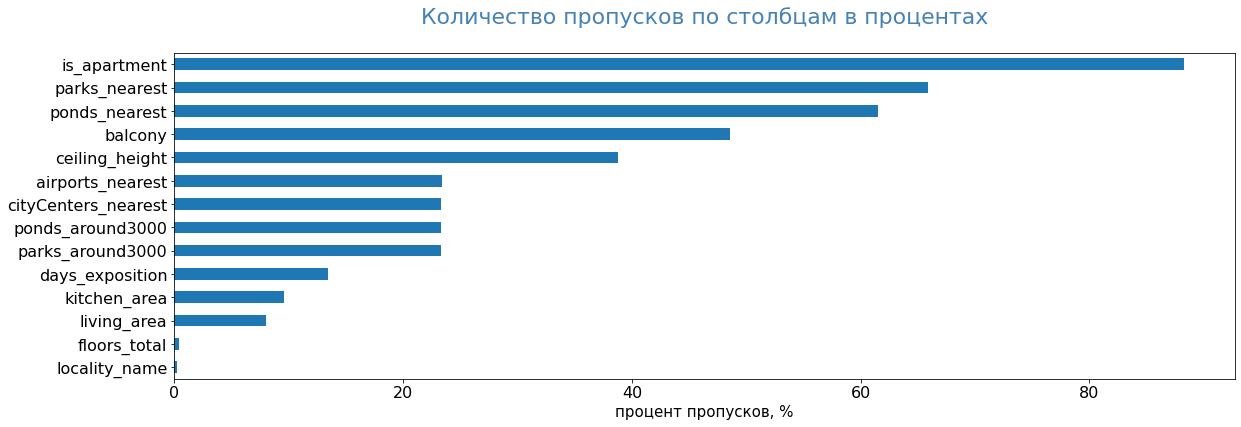

In [10]:
pass_value_barh(data)

___

Вывод:

<div style="border:solid blue 2px; padding: 20px">     
В датасете обнаружено много пропусков, так же следует поменять тип данных у некоторых переменных
</div>


### Предобработка данных

#### Названия населенных пунктов - locality_name

Удалим из датасета пустые значения в столбце **locality_name**, т.к. пропусков мало по сравнению с общим количеством данных и значение населенного пункта является важным для дальнейшего исследования, а заменить название нельзя

In [11]:
data = data.dropna(subset=['locality_name'])

приведем вссе значения к нижнему регистру и посмотрим на количество уникальных значений

In [12]:
data['locality_name'] = data['locality_name'].str.lower()

In [13]:
len(data['locality_name'].unique())

364

Поробуем отловить неявные дубликаты

Просматривать 364 значения для поиска дубликатов не лучший вариант, тогда используем алгоритм Левенштейна, который будет искать наибыстрейший способ перевести одну строку в другую и если количество шагов мало, сохранит эти строки, которые с большей вероятностью будут дубликатами, чем остальные

In [14]:
!pip install editdistance

In [15]:
import editdistance

In [16]:
def custom_find_duplicates(names):
    threshold = 3 # параметр равный 3 является оптимальным для данного случая
    duplicates = []
    for i, row1 in enumerate(names):
        for j, row2 in enumerate(names):
            # вычисление расстояния Левенштейна между строками
            try:
                distance = editdistance.eval(row1, row2)
            except:
                print(i,row1)
                print(j,row2)
            # если расстояние меньше порогового значения и строки не являются одной и той же строкой
            if distance < threshold and i != j:
                # добавление дубликата в список
                duplicates.append((i, j))
    
    return duplicates

In [17]:
print('Количество подозрительных пар - ', len(custom_find_duplicates(data['locality_name'].unique())))

Количество подозрительных пар -  84


In [18]:
for i in custom_find_duplicates(data['locality_name'].unique()):
    print(data['locality_name'].unique()[i[0]],' != ',data['locality_name'].unique()[i[1]])

городской посёлок янино-1  !=  городской поселок янино-1
посёлок мурино  !=  поселок мурино
посёлок мурино  !=  посёлок сумино
поселок городского типа красный бор  !=  посёлок городского типа красный бор
поселок мурино  !=  посёлок мурино
поселок мурино  !=  поселок сумино
посёлок городского типа лебяжье  !=  поселок городского типа лебяжье
поселок городского типа кузьмоловский  !=  посёлок городского типа кузьмоловский
посёлок аннино  !=  поселок аннино
посёлок новый свет  !=  поселок новый свет
поселок новый свет  !=  посёлок новый свет
деревня кальтино  !=  деревня калитино
посёлок бугры  !=  поселок бугры
поселок бугры  !=  посёлок бугры
поселок городского типа рощино  !=  посёлок городского типа рощино
посёлок городского типа красный бор  !=  поселок городского типа красный бор
посёлок победа  !=  поселок победа
посёлок городского типа кузьмоловский  !=  поселок городского типа кузьмоловский
поселок терволово  !=  посёлок терволово
посёлок петровское  !=  поселок петровское
посёло

Оказалось все было гораздо проще и дубликаты возникли из-за буквы "е" вместо "ё".

Тогда заменим все "ё" на "е"

In [19]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('ё','е')

In [20]:
len(data['locality_name'].unique())

330

Получилось отловить 34 дубликата. Проверим еще раз на всякий случай

In [21]:
for i in custom_find_duplicates(data['locality_name'].unique()):
    print(data['locality_name'].unique()[i[0]],' != ',data['locality_name'].unique()[i[1]])

поселок парголово  !=  поселок гарболово
поселок мурино  !=  поселок сумино
поселок городского типа сиверский  !=  поселок городского типа советский
деревня кальтино  !=  деревня калитино
поселок городского типа советский  !=  поселок городского типа сиверский
деревня калитино  !=  деревня кальтино
поселок щеглово  !=  поселок углово
поселок углово  !=  поселок щеглово
поселок саперный  !=  поселок саперное
поселок семрино  !=  поселок сумино
поселок сумино  !=  поселок мурино
поселок сумино  !=  поселок семрино
поселок саперное  !=  поселок саперный
деревня тарасово  !=  деревня торосово
деревня торосово  !=  деревня тарасово
деревня курковицы  !=  деревня куровицы
поселок гарболово  !=  поселок парголово
деревня куровицы  !=  деревня курковицы
деревня рапполово  !=  деревня лупполово
деревня лупполово  !=  деревня рапполово


Остались только существующие населенные пункты с похожими названиями

In [22]:
# check
data.locality_name.nunique()

330

In [23]:
data[data.duplicated()].shape

(0, 22)

In [24]:
data[data.duplicated(subset=['total_area','floor','locality_name','cityCenters_nearest','rooms'])].shape

(350, 22)

Прямых дубликатов нет, но зато есть дубликаты по основным параметрам (возможно просто совпадения)

#### Количество балконов - balcony

Заполним пропуски в колонке с количеством балконов нулями

In [25]:
data['balcony'] = data['balcony'].fillna(0)

Сразу заменим тип на **int**

In [26]:
data['balcony'] = data['balcony'].astype('int')

#### Апартаменты - is_apartment

In [27]:
data['is_apartment'].isna().sum() / data.shape[0] * 100

88.32980972515855

Пропуски составляют 88% от всей таблицы, это очень много. Нужно отметить, что статус апартаментов для продаваемой недвижимости играет значительную роль(накладывает некоторые ограничения, что может сказаться на стоимости), потому этот столбец нужно оставить и заменить пропуски либо на False, либо на нестандартное значение.

Остановимся на втором способе

In [28]:
data['is_apartment'] = data['is_apartment'].astype('string')

In [29]:
data['is_apartment'] = data['is_apartment'].fillna('unknown')

#### Дата публикации - first_day_exposition

Заменим тип данных на datetime

In [30]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

#### Количество парков и водоемов в радиусе 3км - parks_around3000, ponds_around3000

Заменим пропуски на "0", т.к. можно предположить, что эти данные не указали, потомц что парков нет

In [31]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Так как, эти строки сожержат количество парков, приведем тип данных к **int**

In [32]:
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

#### Расстояние до ближайшего парка/водоема - parks_nearest, ponds_nearest

Можно было бы предложить замену на среднее/медиану по группировке по местоположению, но т.к. у нас указан только населенный пункт это будет неточная информация, потому заменим на нестандартное значение "-1"

In [33]:
data['parks_nearest'] = data['parks_nearest'].fillna(-1)
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1)

In [34]:
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int')

Так же заменим тип данных на int, т.к. измерения сделаны в метрах, а нам не нужна большая точность

#### Площадь: жилая и кухня - living_area, kitchen_area

In [35]:
data[(data['total_area']-data['living_area']-data['kitchen_area']) < 0 ].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14,1,2.65,9.0,26.10,5,unknown,False,False,6.20,0,санкт-петербург,13952.0,15031.0,0,-1,1,824,12.0
545,9,4700000.0,23.80,2018-12-28,1,NaN,18.0,20.00,9,unknown,False,False,5.00,0,санкт-петербург,9731.0,11849.0,0,-1,0,-1,108.0
551,8,3100000.0,31.59,2018-03-08,1,2.70,19.0,30.55,2,unknown,False,False,9.28,2,поселок мурино,NaN,NaN,0,-1,0,-1,70.0
601,12,5600000.0,53.70,2017-04-18,2,2.50,12.0,48.30,5,unknown,False,False,7.00,2,санкт-петербург,50477.0,13252.0,2,220,1,1250,167.0
696,1,3364930.0,34.69,2014-11-27,1,2.64,25.0,23.43,25,unknown,False,False,23.43,2,санкт-петербург,43396.0,12153.0,0,-1,0,-1,574.0


In [36]:
print(data['living_area'].isna().sum())
print(data['kitchen_area'].isna().sum())

1898
2269


Пропусков слишком много, чтобы удалить данные. Но и заменять на что-то нестандартное не хочется. Посмотрим на зависимость пропусков с такми параметрами, как studio и open_plan (как удачно, что в этих данных у нас нету пропусков)

**Предположение:** площадь кухни или жилая площадь не указывается в квартирах студиях и в кавртирах с открытой планировкой

Открытая планировка - open_plan:

In [37]:
print('Квартир с открытой планировкой',data[data['open_plan']].shape[0])
print('Квартир с открытой планировкой и пропуском в площади кухни',
      data[(data['open_plan'])&(data['kitchen_area'].isna())].shape[0])

Квартир с открытой планировкой 67
Квартир с открытой планировкой и пропуском в площади кухни 67


Вероятнее всего площадь кухни не указана намеренно, так как ее нельзя посчитать. Заменим ее на 0, так как в данном случае кухня входит в жилую площадь

In [38]:
data['kitchen_area'] = data['kitchen_area'].where(~((data['open_plan'])&(data['kitchen_area'].isna())),0)

Квартира студия - studio:

In [39]:
print('Квартир студий',data[data['studio']].shape[0])
print('Квартир студий и пропуском в площади кухни',data[(data['studio'])&(data['kitchen_area'].isna())].shape[0])


Квартир студий 149
Квартир студий и пропуском в площади кухни 149


Вероятнее всего площадь кухни не указана намеренно, так как ее нельзя посчитать. Заменим ее на 0, так как в данном случае кухня входит в жилую площадь

In [40]:
data['kitchen_area'] = data['kitchen_area'].where(~((data['studio'])&(data['kitchen_area'].isna())),0)

Посмотрим на жилую площадь:

Заметим, что иногда сумма жилой площади и площадь кухни превышает общую площадь. Это настораживает

In [41]:
data[(data['total_area']-data['living_area']-data['kitchen_area']) < 0 ].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14,1,2.65,9.0,26.10,5,unknown,False,False,6.20,0,санкт-петербург,13952.0,15031.0,0,-1,1,824,12.0
545,9,4700000.0,23.80,2018-12-28,1,NaN,18.0,20.00,9,unknown,False,False,5.00,0,санкт-петербург,9731.0,11849.0,0,-1,0,-1,108.0
551,8,3100000.0,31.59,2018-03-08,1,2.70,19.0,30.55,2,unknown,False,False,9.28,2,поселок мурино,NaN,NaN,0,-1,0,-1,70.0
601,12,5600000.0,53.70,2017-04-18,2,2.50,12.0,48.30,5,unknown,False,False,7.00,2,санкт-петербург,50477.0,13252.0,2,220,1,1250,167.0
696,1,3364930.0,34.69,2014-11-27,1,2.64,25.0,23.43,25,unknown,False,False,23.43,2,санкт-петербург,43396.0,12153.0,0,-1,0,-1,574.0


Остальные пропуски заменим на нестандартное значение "-1" 

In [42]:
data['kitchen_area'] = data['kitchen_area'].fillna(-1)
data['living_area'] = data['living_area'].fillna(-1)

#### Расстояния до аэропорта и центра - airports_nearest, cityCenters_nearest

In [43]:
data['airports_nearest'].describe()

count    18116.000000
mean     28803.225878
std      12637.314144
min          0.000000
25%      18575.750000
50%      26756.500000
75%      37294.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Довольно для большого числа квартир, расстояние до аэропорта указано как 0

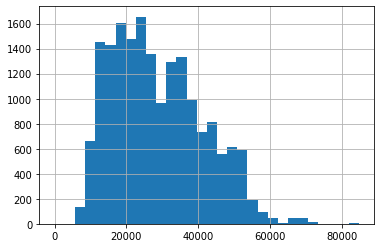

In [44]:
data['airports_nearest'].hist(bins=30);

In [45]:
data = data.query('airports_nearest != 0')

In [46]:
data['cityCenters_nearest'].describe()

count    18138.000000
mean     14197.386426
std       8606.830485
min        181.000000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Найдем населенные пункты, где ни у одной квартиры не указано расстояние до аэропорта

In [47]:
nan_dist = data.pivot_table(index='locality_name',values='airports_nearest',aggfunc='sum')
nan_dist = nan_dist[nan_dist['airports_nearest']==0]
nan_dist

,airports_nearest
locality_name,
бокситогорск,0.0
волосово,0.0
волхов,0.0
всеволожск,0.0
выборг,0.0
...,...
сосновый бор,0.0
сясьстрой,0.0
тихвин,0.0


Так как в этих населенных пунктах нельзя найти среднее, заменим пропуски на "-1"

In [48]:
data['airports_nearest'] = data['airports_nearest'].where(~(data['locality_name'].isin(nan_dist.index)),-1)

Количество пропусков скоратилось

In [49]:
data['airports_nearest'].isna().sum()

670

 Составим сводную табличку и найдем медиану,среднее и количество

In [50]:
airports_good_data = (
    data[data['airports_nearest'] != -1]
    .pivot_table(index='locality_name',values='airports_nearest',aggfunc=['mean','median','count'])
)
airports_good_data.columns = ['mean','median','count']
airports_good_data.head()


,mean,median,count
locality_name,,,
зеленогорск,73300.250000,72282.0,24
колпино,26375.863501,26232.0,337
красное село,26595.579545,25715.5,176
кронштадт,67469.263158,67850.0,95
ломоносов,48308.280303,48415.5,132


Отбросим значения,где количество меньше 20

In [51]:
airports_good_data = airports_good_data.query('count >= 20')
airports_good_data

,mean,median,count
locality_name,,,
зеленогорск,73300.250000,72282.0,24
колпино,26375.863501,26232.0,337
красное село,26595.579545,25715.5,176
кронштадт,67469.263158,67850.0,95
ломоносов,48308.280303,48415.5,132
павловск,21053.342105,20529.5,38
петергоф,40184.676617,39231.0,201
поселок металлострой,25726.484848,25758.0,66
поселок парголово,53994.926606,53426.0,327


Снова найдем населенные пункты, где есть пропуски

In [52]:
nan_airports_good_data = (
    data[data['airports_nearest'].isna()]
    .pivot_table(index='locality_name',values='airports_nearest',aggfunc=['sum'])
)
nan_airports_good_data.columns = ['sum']
nan_airports_good_data

,sum
locality_name,
колпино,0.0
красное село,0.0
кронштадт,0.0
ломоносов,0.0
поселок мурино,0.0
поселок шушары,0.0
поселок щеглово,0.0
санкт-петербург,0.0


получим нужные поселки

In [53]:
airports_good_data = airports_good_data.join(nan_airports_good_data, how='inner')
airports_good_data

,mean,median,count,sum
locality_name,,,,
колпино,26375.863501,26232.0,337,0.0
красное село,26595.579545,25715.5,176,0.0
кронштадт,67469.263158,67850.0,95,0.0
ломоносов,48308.280303,48415.5,132,0.0
поселок шушары,16061.458716,17427.0,436,0.0
санкт-петербург,28047.980045,26758.0,15635,0.0


In [54]:
def set_distance(val):
    if val['locality_name'] in airports_good_data.index and pd.isna(val['airports_nearest']):
        val['airports_nearest'] = airports_good_data.loc[val['locality_name'],'median']
        return val
    return val

In [55]:
data = data.apply(set_distance,axis=1)

Остальные пропуски и нулевые значения заполним "-1"

In [56]:
data['airports_nearest'] = data['airports_nearest'].where(~((data['airports_nearest'].isna())),-1)

Так как внутри города, квартиры могут находится совершенно на разном расстоянии от центра, заполним пропуски "-1"

In [57]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].where(~(data['cityCenters_nearest'].isna()),-1)

Заменим тип данных на int

In [58]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')
data['airports_nearest'] = data['airports_nearest'].astype('int')

#### Высота потолков - ceiling_height

In [59]:
data['ceiling_height'].describe()

count    14489.000000
mean         2.771292
std          1.261637
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

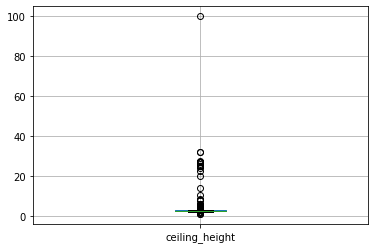

In [60]:
data.boxplot('ceiling_height');

Видно, что есть явные аномалии. Высота потолков в некоторых квартирах превышает 5 метров, есть квартира с высотой 100 метров и 1 метр.

Значения меньше 2.1 и больше 5 метров. 

In [61]:
ceiling_median = data['ceiling_height'].median()

Если значение больше 20, то можно разделить на 10 и получить значение в метрах

In [62]:
def change_ceil(val):
    if val > 21:
        return val / 10
    return val

In [63]:
data['ceiling_height']  = data['ceiling_height'].apply(change_ceil)

Заменить пропуски на медиану проблематично. Их очень много и так же мы не можем найти медиану по меньшим сгруппированным выборка, чтобы например учесть районность. Потому заменим на -1

In [64]:
data['ceiling_height'] = data['ceiling_height'].fillna(-1)

In [65]:
data = data.query('ceiling_height < 5 and (ceiling_height > 2 or ceiling_height == -1)')

#### Количество этажей - floors_total

In [66]:
data['floors_total'].describe()

count    23534.000000
mean        10.677445
std          6.593961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

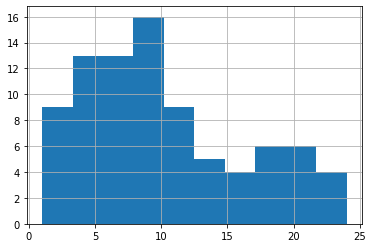

In [67]:
data[data['floors_total'].isna()]['floor'].hist();

Заменим пропуски "-1". Можно конечно заменить на значение этажа, но тогда в дальнейшем это повлияет на категорию квартиры ("первый этаж", "последний этаж", "другое")

In [68]:
data['floors_total'] = data['floors_total'].fillna(-1)

In [69]:
data['floors_total'] = data['floors_total'].astype('int')

#### Сколько дней было размещено объявление - days_exposition

In [70]:
data['days_exposition'].describe()

count    20445.00000
mean       180.75911
std        219.80465
min          1.00000
25%         45.00000
50%         95.00000
75%        231.00000
max       1580.00000
Name: days_exposition, dtype: float64

<AxesSubplot:>

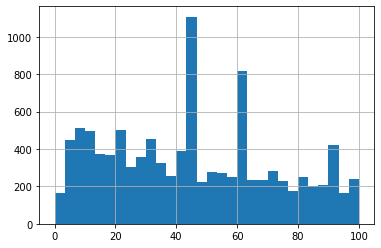

In [71]:
data['days_exposition'].hist(bins=30,range=(0,100))

In [72]:
data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

In [73]:
data[data['days_exposition'].isna()]['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

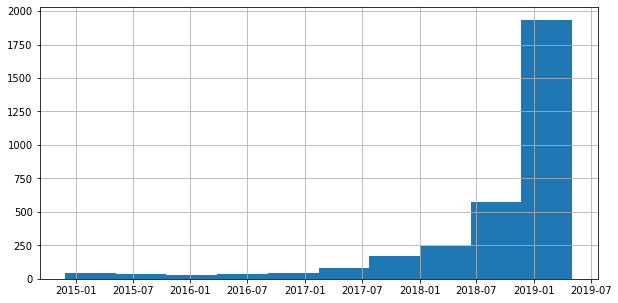

In [74]:
data[data['days_exposition'].isna()]['first_day_exposition'].hist(figsize=(10,5));

Можно предположить, что пропуски находятся в еще активных объявлениях

In [75]:
def find_last_day(val):
    return val['first_day_exposition'] + pd.Timedelta(days=val['days_exposition'])

In [76]:
data[~data['days_exposition'].isna()].apply(find_last_day,axis=1).max()

Timestamp('2019-05-02 00:00:00')

Тогда заменим пропуски на нестандартные значения "-1":

In [77]:
data['days_exposition'] = data['days_exposition'].fillna(-1)

Заменим тип данных на int

In [78]:
data['days_exposition'] = data['days_exposition'].astype('int')

#### Посмотрим на наличие аномалий и выбросов:

In [79]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max','median','mean'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,619.00","23,619.00","23,619.00","23,619.00","23,619.00","23,619.00","23,619.00","23,619.00","23,619.00"
min,0.00,12.00,-1.00,-1.00,"12,190.00",-1.00,-1.00,1.00,-1.00
max,19.00,900.00,4.90,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00
median,2.00,52.00,2.50,73.00,"4,650,000.00",29.00,9.00,4.00,9.00
mean,2.07,60.30,1.28,156.33,"6,526,138.33",31.59,9.47,5.89,10.64


In [80]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.00,-1.00,-1.00,"570,124.00",-1.00,-1.00,1.00,-1.00
0.01,1.00,25.20,-1.00,-1.00,"1,000,000.00",-1.00,-1.00,1.00,2.00
0.5,2.00,52.00,2.50,73.00,"4,650,000.00",29.00,9.00,4.00,9.00
0.99,5.00,197.00,3.55,"1,044.64","35,828,000.00",115.00,35.00,23.00,26.00
0.9988,8.00,378.16,4.20,"1,361.66","124,435,592.00",214.29,56.13,26.00,34.66


##### Взглянем на rooms

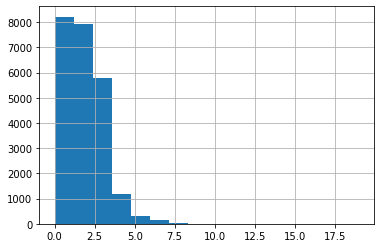

In [81]:
data.rooms.hist(bins=16);

In [82]:
data.rooms.value_counts()

1     8022
2     7918
3     5791
4     1174
5      324
0      196
6      104
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Уберем из данных квартиры с 8 и более комнатами

In [83]:
print('Процент удаляемых данных -',data.query('rooms >= 8 ').shape[0]/data.shape[0] * 100)

Процент удаляемых данных - 0.13125026461746897


In [84]:
data = data.query('rooms < 8 ')

In [85]:
print(data.query('rooms == 0 and studio').shape[0])
print(data.query('rooms == 0 and open_plan').shape[0])

137
59


там где 0 и квартира студияили открытой планировки, заменим на 1

In [86]:
data['rooms'] = data['rooms'].where(~(((data['studio']) | (data['open_plan'])) & (data['rooms'] == 0)),1)

##### Взглянем на total_area

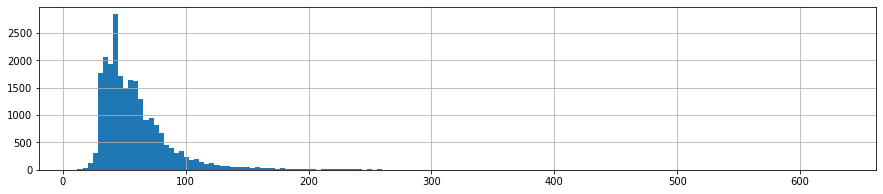

In [87]:
data.total_area.hist(bins=150,figsize = (15,3));

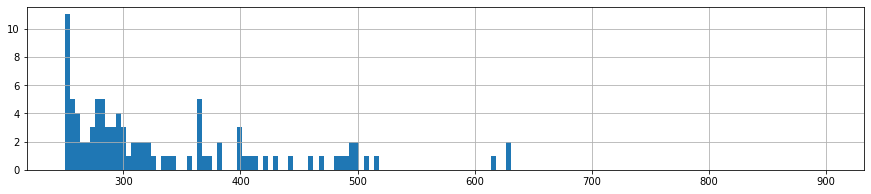

In [88]:
data.total_area.hist(bins=150,figsize = (15,3),range=(250,900));

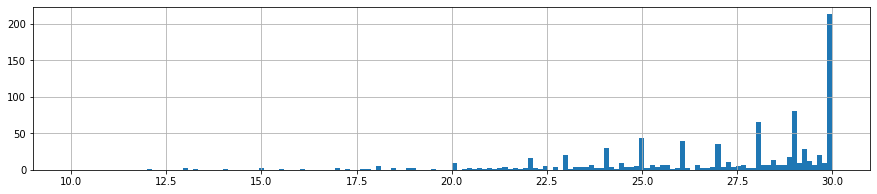

In [89]:
data.total_area.hist(bins=150,figsize = (15,3),range=(10,30));

Удалим квартиры где площадь больше 250 и меньше 20

In [90]:
print('Процент удаляемых данных -',
      (1 - data.query('total_area < 250 and total_area > 20').shape[0]/data.shape[0]) * 100)

Процент удаляемых данных - 0.5553671358317747


In [91]:
data = data.query('total_area < 250 and total_area > 20')

In [92]:
data.shape

(23457, 22)

##### Взглянеем на days_exposition без значений -1

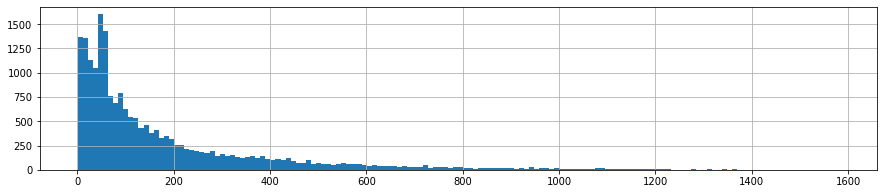

In [93]:
data.query('days_exposition != -1').days_exposition.hist(bins=150,figsize = (15,3));

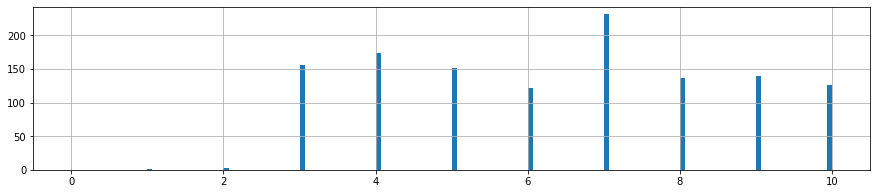

In [94]:
data.query('days_exposition != -1').days_exposition.hist(bins=150,figsize = (15,3),range=(0,10));

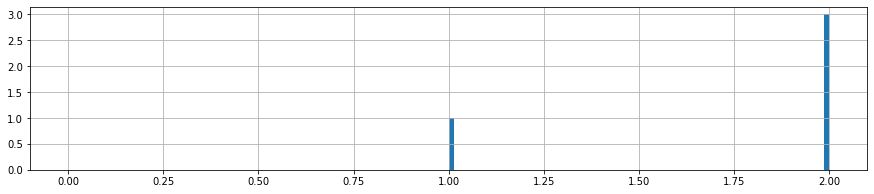

In [95]:
data.query('days_exposition != -1').days_exposition.hist(bins=150,figsize = (15,3),range=(0,2));

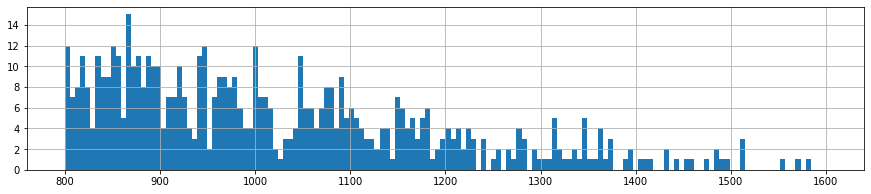

In [96]:
data.query('days_exposition != -1').days_exposition.hist(bins=150,figsize = (15,3),range=(800,1600));

In [97]:
print('Процент удаляемых данных -',
      (1 - data.query('days_exposition < 1000').shape[0]/data.shape[0]) * 100)

Процент удаляемых данных - 1.1638316920322245


In [98]:
data = data.query('days_exposition < 1000')

##### Взглянем на last_price

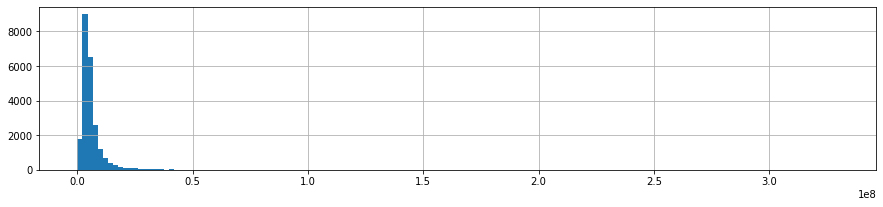

In [99]:
data.last_price.hist(bins=150,figsize = (15,3));

количество квартир больше 50млн рублей

In [100]:
data.query('last_price > 40000000').shape

(111, 22)

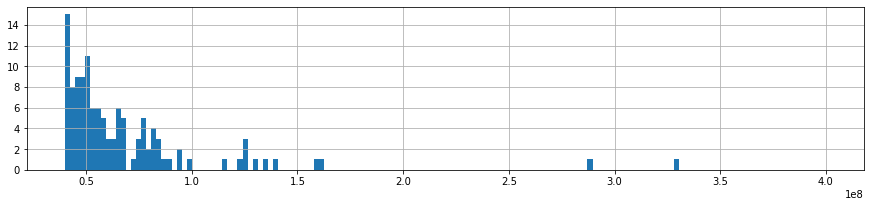

In [101]:
data.last_price.hist(bins=150,figsize = (15,3),range=(40000000,400000000));

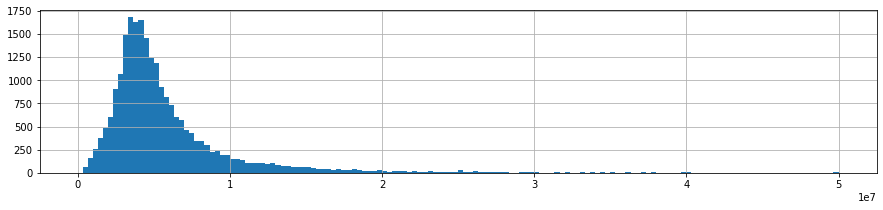

In [102]:
data.last_price.hist(bins=150,figsize = (15,3),range=(0,50000000));

Количество квартир меньше 0.9млн руб

In [103]:
data.query('last_price < 900000').shape

(156, 22)

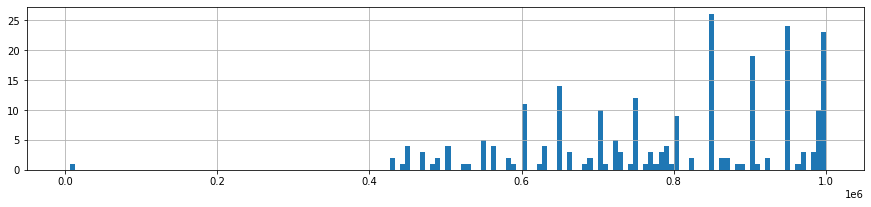

In [104]:
data.last_price.hist(bins=150,figsize = (15,3),range=(0,1000000));

Возьмем квартиры в диапазоне от 0.9млн до 40 млн

In [105]:
print('Процент удаляемых данных -',
      (1 - data.query('last_price > 900000 and last_price < 40000000').shape[0]/data.shape[0]) * 100)

Процент удаляемых данных - 1.2767425810904065


In [106]:
data = data.query('last_price > 900000 and last_price < 40000000')

##### Посмотрим на living_area

In [107]:
data.query('living_area != -1').living_area.describe()

count    21088.000000
mean        33.319381
std         17.872639
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        184.000000
Name: living_area, dtype: float64

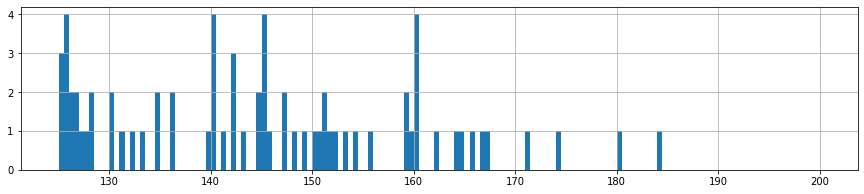

In [108]:
data.query('living_area != -1').living_area.hist(bins=150,figsize = (15,3),range=(125,200));

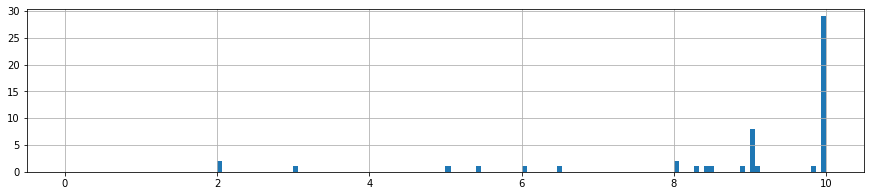

In [109]:
data.query('living_area != -1').living_area.hist(bins=150,figsize = (15,3),range=(0,10));

In [110]:
print('Процент удаляемых данных -',
      (1 - data.query('living_area == -1 or (living_area < 170 and living_area > 7)').shape[0]/data.shape[0]) * 100)

Процент удаляемых данных - 0.048060118839565735


In [111]:
data = data.query('living_area == -1 or (living_area < 170 and living_area > 7)')

##### Взглянем на kitchen_area

In [112]:
data.query('kitchen_area > 0').kitchen_area.describe()

count    20725.000000
mean        10.346975
std          5.155462
min          1.300000
25%          7.000000
50%          9.000000
75%         11.900000
max         70.000000
Name: kitchen_area, dtype: float64

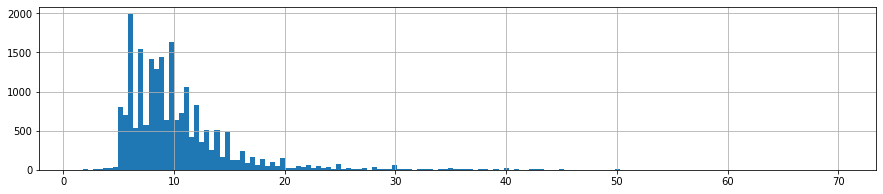

In [113]:
data.query('kitchen_area > 0').kitchen_area.hist(bins=150,figsize = (15,3));

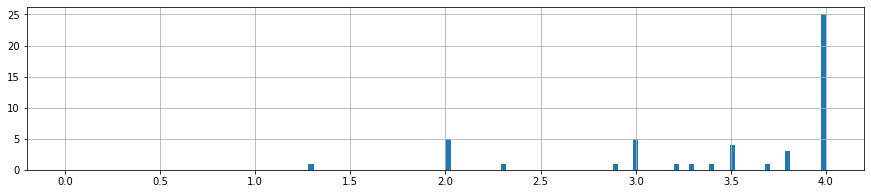

In [114]:
data.query('kitchen_area > 0').kitchen_area.hist(bins=150,figsize = (15,3),range=(0,4));

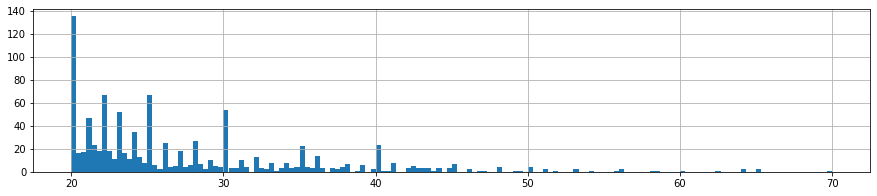

In [115]:
data.query('kitchen_area > 0').kitchen_area.hist(bins=150,figsize = (15,3),range=(20,70));

In [116]:
data = data.query('kitchen_area <= 0 or kitchen_area >= 4')

Посмотрим на сводку еще раз

In [117]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max','median','mean'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,853.00","22,853.00","22,853.00","22,853.00","22,853.00","22,853.00","22,853.00","22,853.00","22,853.00"
min,1.00,20.10,-1.00,-1.00,"910,000.00",-1.00,-1.00,1.00,-1.00
max,7.00,248.00,4.80,999.00,"39,990,000.00",167.00,70.00,33.00,60.00
median,2.00,52.00,2.50,71.00,"4,600,000.00",29.00,9.00,4.00,9.00
mean,2.05,58.26,1.28,143.78,"5,857,218.89",30.61,9.30,5.93,10.73


Вывод по аномалиям:

Во всех рассматриваемых столбцах были удалены редкие граничные значения, которые впоследствии могли выбиваться из общей картины 

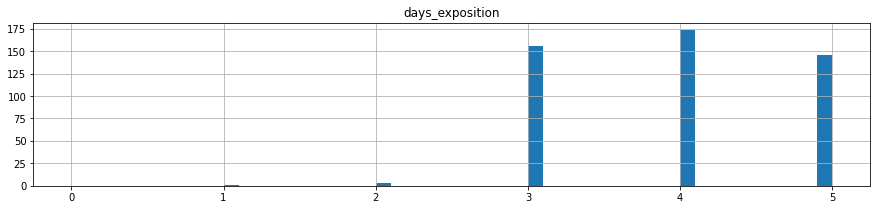

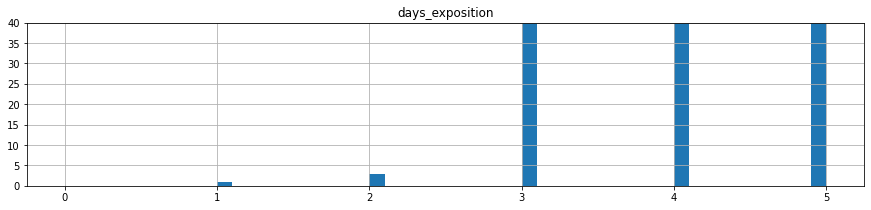

In [118]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

___

Общий вывод по предобработке:

<div style="border:solid blue 2px; padding: 20px">     
Весь датасет был просмотрен, все пропуски заменены, найденные дубликаты убраны, встречающиеся по ходу решения задач аномалии убраны.
    
Краткий план проведенных действий:
    
    - найдены и убраны дубликаты из-за букв "е" и "ё" в названиях населенных пунктов
    
    - пропуски в количестве балконах заменены на 0, приведено к типу int
    
    - пропуски в параметре is_apartment заменены на "unknown", так как этот параметр является важным и может накладывать определенные ограничения на жилплощадь, приведено к типу string
    
    - дата публикации приведена к типу datetime
    
    - пропуски в количестве водоемов и парков в радиусе 3км заменены на 0, приведено к типу int
    
    - пропуски в расстоянии до ближайщего парка или водоема заменены на -1, приведено к int
    
    - найдена зависимость между пропуском в параметре kitchen_area и параметрами open_plan и studio, так как в квартирах такого типа площадь кухни не указывается. Пропуски заменены на 0
    
    - пропуски в living_area и остальные пропуски в kitchen_area  заменены на -1, так как нельзя посчитать разницу между кухней, жилой площадью и общей, так как это приведет к неточностям
    
    - замечена особенность - в некоторых квартирах сумма жилой площади и площади кухни превыщает общую площадь
    
    - пропуски в расстоянии до центра заменены на -1, приведено к int
    
    - пропуски в расстоянии до аэропорта заменены на медианное значение по городу, если в городе больше 20 предложений без пропусков, по которым можно посчитать значение. В остальных случаях так же заменено на -1, приведено к int
    
    - замечено много аномалий в параметре высота потолков (до 100 метров при норме от 2.2 до 3). Аномалии заменены медианным значением
    
    - пропуски в высоте потолков заменены медианным значением 
    
    - пропуски в количестве этажей заменены на -1, приведено к int
    
    - определено, что с большой вероятность пропуски в количестве дней с момента выставления объявления находятся в тех объявлениях, которые еще активны. Пропуски заменены на -1, из расчета, что в дальнейшем эта переменная будет использоваться. Приведено к типу int
    
    - найдены и убраны выбросы и аномалии 
    
</div>


### Проведите исследовательский анализ данных

#### Добавим столбцы, которые пригодятся потом

Добавим столбец - цена одного квадратного метра

In [128]:
data['price_per_area'] = data['last_price']/data['total_area']

Добавим день, месяц и год публикации

In [129]:
data['day_of_exposition'] = data['first_day_exposition'].dt.weekday
data['month_of_exposition'] = data['first_day_exposition'].dt.month
data['year_of_exposition'] = data['first_day_exposition'].dt.year

Добавим тип этажа - floors_total,  floor 

In [130]:
data['floor'].describe()

count    22853.000000
mean         5.932394
std          4.897687
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:>

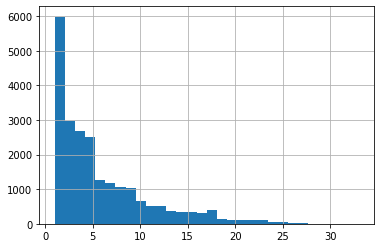

In [131]:
data['floor'].hist(bins=30)

In [132]:
def floor_type(val):
    floor = val['floor']
    total = val['floors_total']
    if floor == 1:

        return 'первый'
    elif floor == total:

        return 'последний'

    return 'другой'

In [133]:
data['floor_type'] = data.apply(floor_type,axis=1)

Добавим расстояние до центра города в км - cityCenters_nearest

In [134]:
def city_center(val):
    if val == -1:
        return -1
    return np.round(val/1000)

In [135]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'].apply(city_center)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype('int')

In [136]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_exposition,month_of_exposition,year_of_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,unknown,False,False,25.0,0,санкт-петербург,18863,16028,1,482,2,755,-1,120370.370370,3,3,2019,другой,16
1,7,3350000.0,40.4,2018-12-04,1,-1.00,11,18.6,1,unknown,False,False,11.0,2,поселок шушары,12817,18603,0,-1,0,-1,81,82920.792079,1,12,2018,первый,19
2,10,5196000.0,56.0,2015-08-20,2,-1.00,5,34.3,4,unknown,False,False,8.3,0,санкт-петербург,21741,13933,1,90,2,574,558,92785.714286,3,8,2015,другой,14
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,unknown,False,False,41.0,0,санкт-петербург,31856,8098,2,112,1,48,121,100000.000000,1,6,2018,другой,8
5,10,2890000.0,30.4,2018-09-10,1,-1.00,12,14.4,5,unknown,False,False,9.1,0,городской поселок янино-1,-1,-1,0,-1,0,-1,55,95065.789474,0,9,2018,другой,-1


#### Изучим некоторые переменные

- **total_area** — общая площадь квартиры в квадратных метрах (м²)

- **living_area** — жилая площадь в квадратных метрах (м²)

- **kitchen_area** — площадь кухни в квадратных метрах (м²)

- **last_price** — цена на момент снятия с публикации

- **rooms** — число комнат

- **ceiling_height** — высота потолков (м)

- **floor** — этаж

- **floor_type** — тип этажа

- **floors_total** — всего этажей в доме

- **cityCenters_nearest** — расстояние до центра города (м)

- **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)

- **parks_nearest** — расстояние до ближайшего парка (м)

- **day_of_exposition** — день недели выставления объявления

- **month_of_exposition** — месяц выставления объявления

In [137]:
def plot_info(df, column, bins= 10,figsize = (15,3),prange=(0,0)):
    print(df[column].describe())
    df.boxplot(column, vert=False,figsize=figsize)
    plt.show() 
    if prange == (0,0):
        prange = (0,df[column].max())
    plot_with_range(df,column,bins = bins,figsize = figsize,range=prange)
    plt.show()
    
def plot_with_range(df, column, bins= 10,range=(0,100),figsize = (15,3)):
    ax = df[column].plot(kind='hist',bins=bins,range=range,grid=True,figsize=figsize)
    ax.axvline(x = df[column].median(), linestyle = '--',color = 'r',label='median')
    ax.axvline(x = df[column].mean(), linestyle = '--',color = 'y',label='mean')
    ax.set_title('частота по '+column + "\n", fontsize = 15, color = 'SteelBlue')
    ax.set_xlabel(column, fontsize = 10) 
    ax.legend(loc='upper right')
    plt.show()

##### Общая площадь - total_area

count    22853.000000
mean        58.255790
std         26.977519
min         20.100000
25%         40.000000
50%         52.000000
75%         68.700000
max        248.000000
Name: total_area, dtype: float64


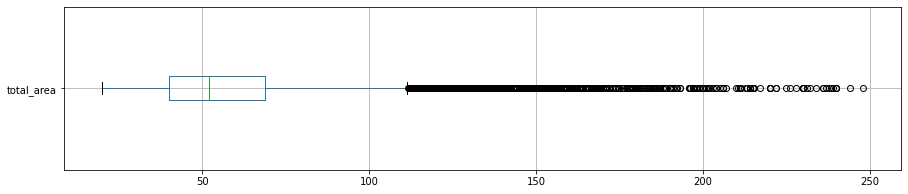

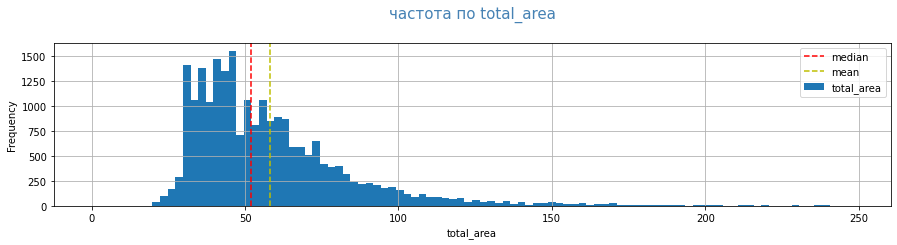

In [138]:
plot_info(data,'total_area',bins=100)

___

Вывод:

Видно, что преобладают квартиры с площадью ~$27-47 м^{2}$

##### Жилая площадь - living_area

Для анализа не будем учитывать заполненные нами значения "-1"

count    21053.000000
mean        33.313419
std         17.763631
min          8.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        167.000000
Name: living_area, dtype: float64


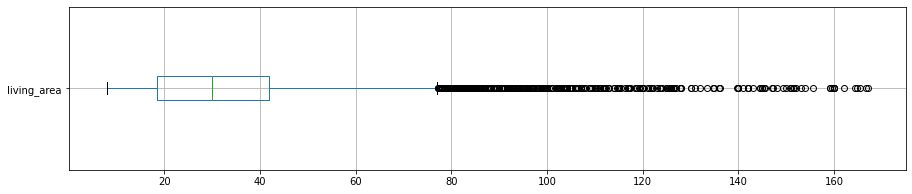

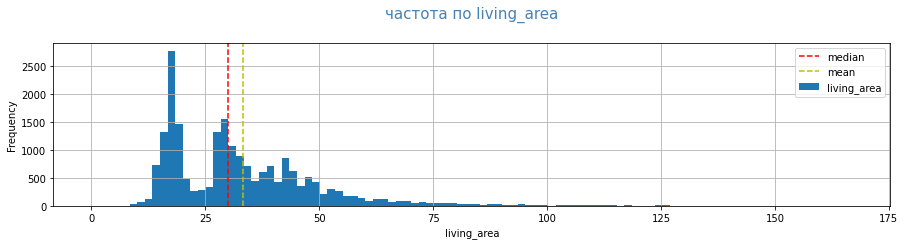

In [139]:
plot_info(data.query('living_area != -1'),'living_area',bins=100)

Посмотрим на диапазон 0-100

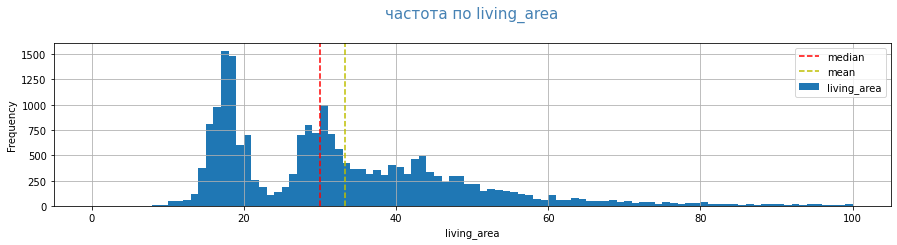

In [140]:
plot_with_range(data.query('living_area != -1'),'living_area',bins=100,range=(0,100))

In [141]:
data.query('living_area != -1')['living_area'].corr(data.query('living_area != -1')['total_area'])

0.9281321816993886

___

Вывод:

Видны два пика, на уровне $18 м^{2}$ и $30  м^{2}$. В остальном графики с общей площадью схожи, что подтверждается высокой корреляцией

##### Площадь кухни - kitchen_area

count    20902.000000
mean        10.255984
std          5.226028
min          0.000000
25%          7.000000
50%          9.000000
75%         11.850000
max         70.000000
Name: kitchen_area, dtype: float64


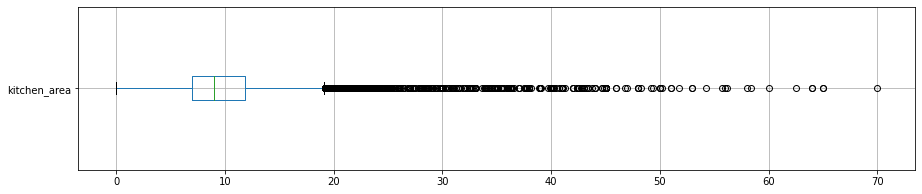

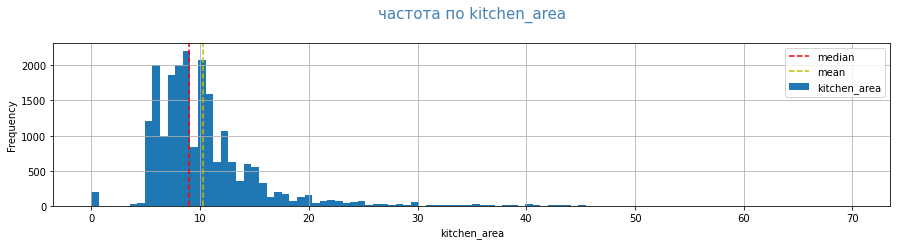

In [142]:
plot_info(data.query('kitchen_area != -1'),'kitchen_area',bins=100)

Посмотрим на диапазон 0-50

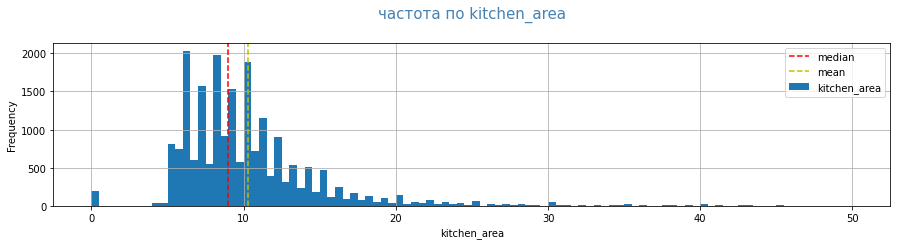

In [143]:
plot_with_range(data.query('kitchen_area != -1'),'kitchen_area',bins=100,range=(0,50))

___

Вывод:

Видно, что часто всторечаются кухни одинаковой площади, что и создает такую дискретность.

##### Цена - last_price

count    2.285300e+04
mean     5.857219e+06
std      4.375155e+06
min      9.100000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.690000e+06
max      3.999000e+07
Name: last_price, dtype: float64


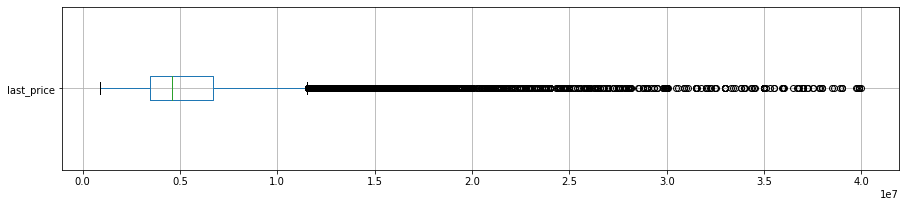

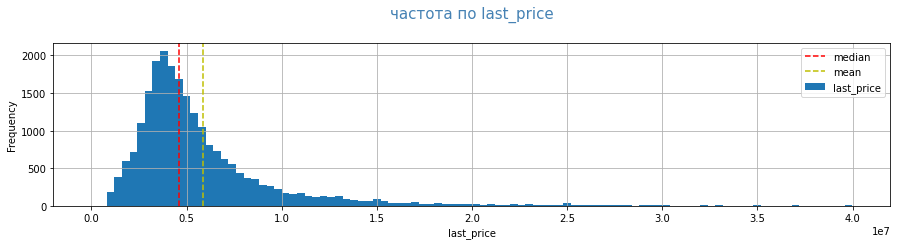

In [144]:
plot_info(data,'last_price',bins=100)

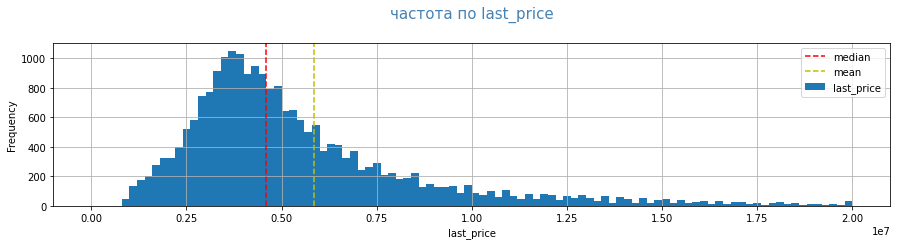

In [145]:
plot_with_range(data,'last_price',bins=100,range=(0,20000000))

___

Вывод:

Виднеется пик в райноне 4 млн. Распределение похоже на пуассоновское

##### Число комнат - rooms

count    22853.000000
mean         2.046909
std          0.989966
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64


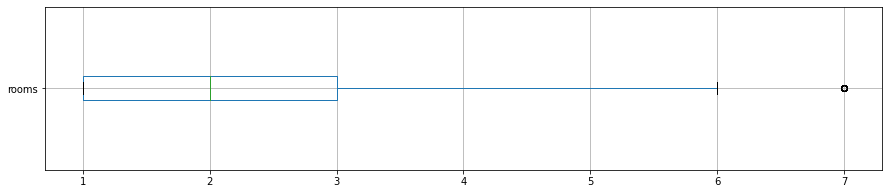

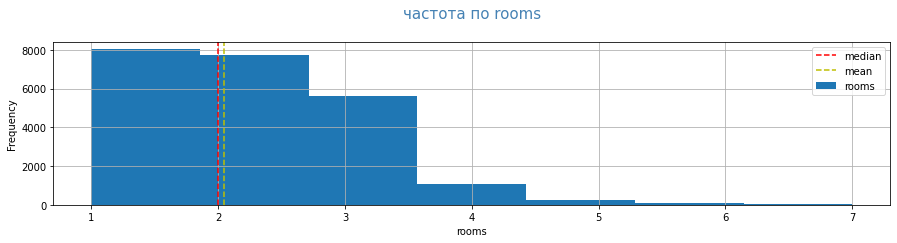

In [146]:
plot_info(data,'rooms',bins=7, prange=(1,7))

In [147]:
data.query('rooms == 1 or rooms == 2 or rooms == 3').shape[0] / data.shape[0]

0.9357633571084759

In [148]:
data.query('rooms == 1 or rooms == 2').shape[0] / data.shape[0]

0.6889686255633833

___

Вывод:

Преобладают квартиры с 1ой, 2мя и 3мя комнатами, они составляют 93% всех квартир

##### Высота потолков - ceiling_height

count    14005.000000
mean         2.717933
std          0.259627
min          2.200000
25%          2.510000
50%          2.650000
75%          2.800000
max          4.800000
Name: ceiling_height, dtype: float64


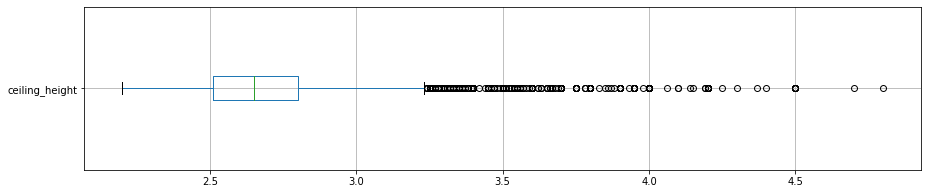

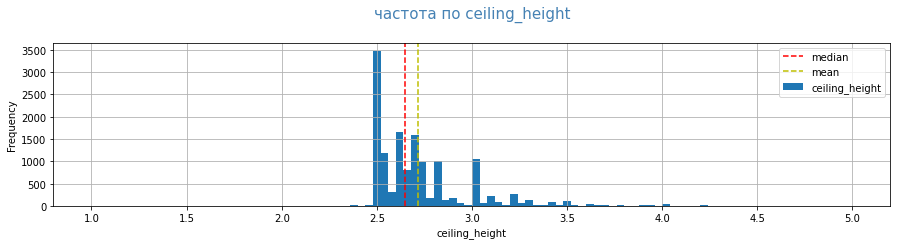

In [149]:
plot_info(data.query('ceiling_height != -1'),'ceiling_height',bins=100,prange=(1,5))

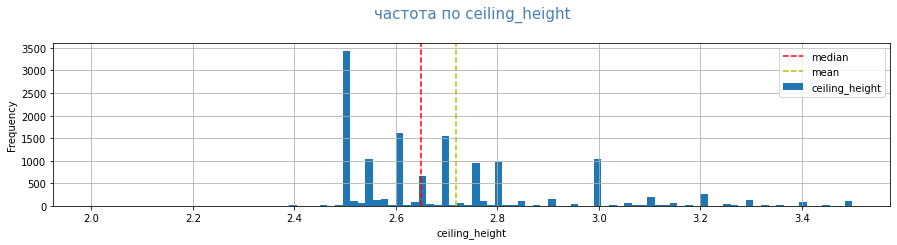

In [150]:
plot_with_range(data.query('ceiling_height != -1'),'ceiling_height',bins=100,range=(2,3.5))


___

Вывод:

Пропуски, замененные на -1, сильно сказываются на данных.
Так же виднеется много пиков, что означает стандартность застройки. Малые значения распределения скорее всего относятся к нетиповой застройке и в особенности к старым зданиям 

##### Этаж - floor

count    22853.000000
mean         5.932394
std          4.897687
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


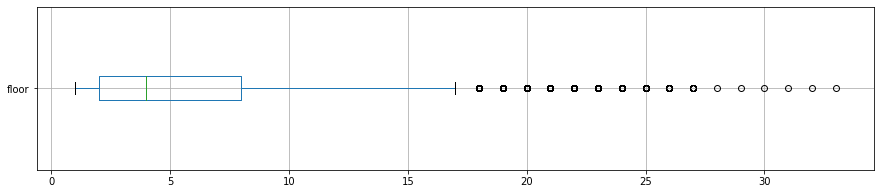

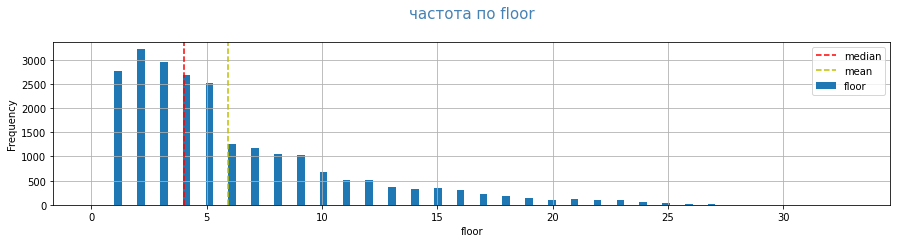

In [151]:
plot_info(data,'floor',bins=100)

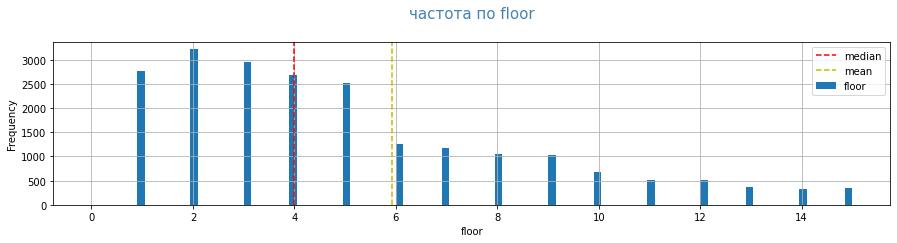

In [152]:
plot_with_range(data,'floor',bins=100,range=(0,15))

___

Вывод:

В продаже преобладают квартиры с 1ого по 5ый этажи, потом резкий спад и планое уменьшение при увеличении этажа

##### Тип этажа - floor_type

In [153]:
data['floor_type'].describe()

count      22853
unique         3
top       другой
freq       16919
Name: floor_type, dtype: object

<AxesSubplot:>

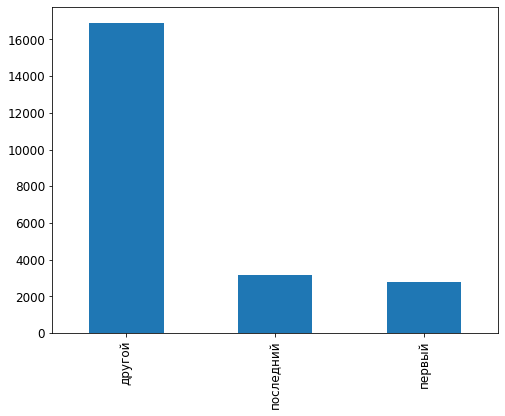

In [154]:
data['floor_type'].value_counts().plot(kind='bar', figsize=(8, 6), fontsize=12)

___

Вывод:

Первые и последние этажи в продаже меньше(что логично ведь их самих меньше), но так же их почти одинаковое количество 

##### Всего этажей - floors_total

count    22772.000000
mean        10.771122
std          6.605462
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


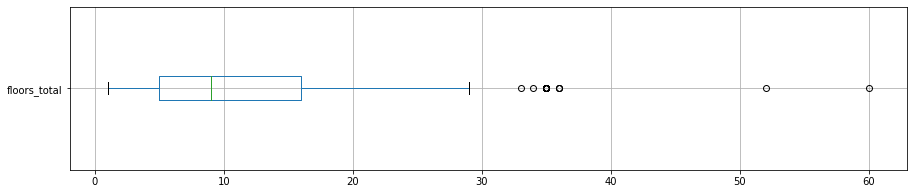

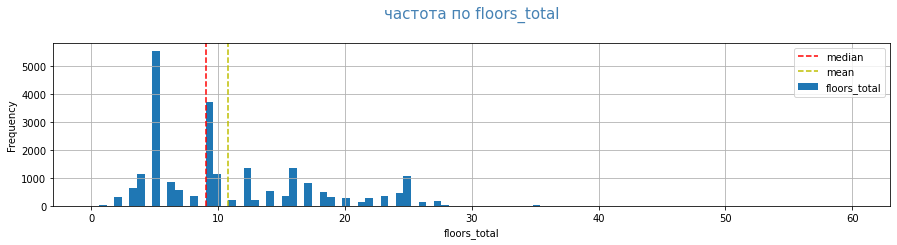

In [155]:
plot_info(data.query('floors_total != -1'),'floors_total',bins=100)

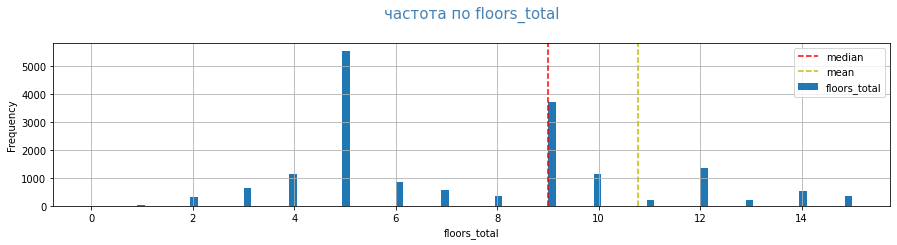

In [156]:
plot_with_range(data.query('floors_total != -1'),'floors_total',bins=100,range=(0,15))

___

Вывод:

В продаже преобладают 5 и 9 этажные здания - здания старой застройки

In [157]:
data.query('floors_total == 5').shape[0] / data.query('floors_total != -1').shape[0]

0.24306165466362198

In [158]:
data.query('floors_total == 9').shape[0] / data.query('floors_total != -1').shape[0]

0.16217284384331634

25% - 5и этажные здания

16% - 9и этажные здания

##### Расстояние до центра - cityCenters_nearest

count    17588.000000
mean     14349.592165
std       8567.783312
min        181.000000
25%       9563.250000
50%      13218.000000
75%      16364.500000
max      65952.000000
Name: cityCenters_nearest, dtype: float64


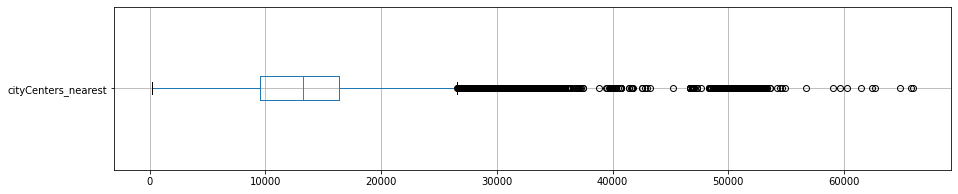

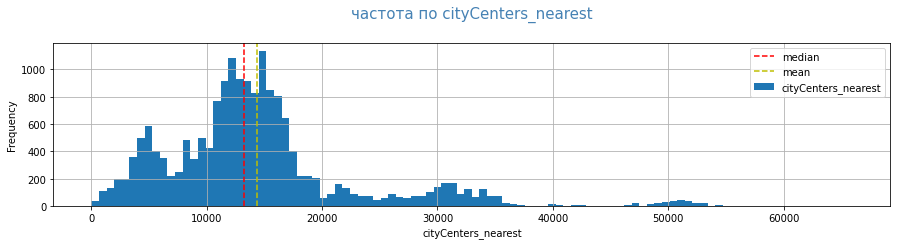

In [159]:
plot_info(data.query('cityCenters_nearest != -1'),'cityCenters_nearest',bins=100)

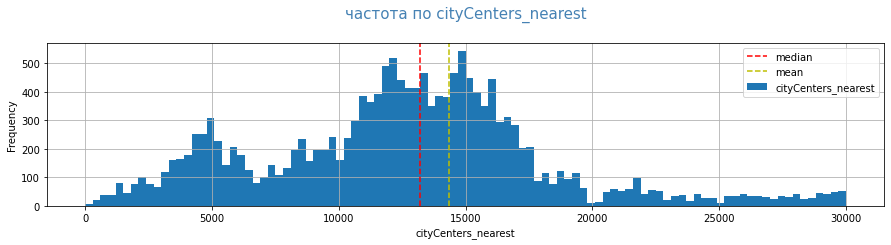

In [160]:
plot_with_range(data.query('cityCenters_nearest != -1'),'cityCenters_nearest',bins=100,range=(0,30000))

___

Вывод:

Явно преобладают квартиры, находящиеся в ~10-18 км, а так же есть небольшое увеличении в районе 5 км

##### Расстояние до аэропорта - airports_nearest

count    17653.000000
mean     28850.995298
std      12696.341106
min       6450.000000
25%      18496.000000
50%      26785.000000
75%      37407.000000
max      84853.000000
Name: airports_nearest, dtype: float64


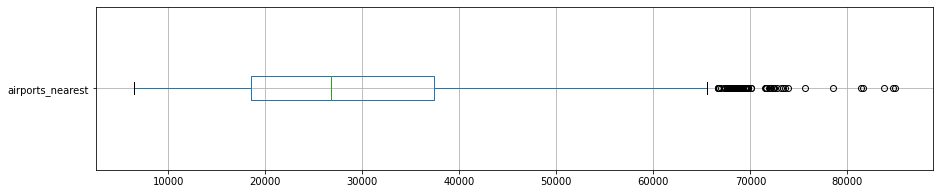

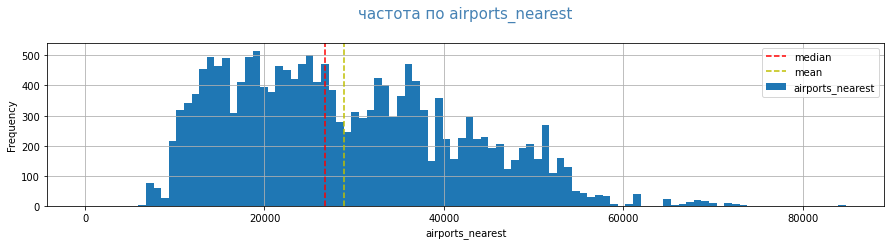

In [161]:
plot_info(data.query('airports_nearest != -1'),'airports_nearest',bins=100)

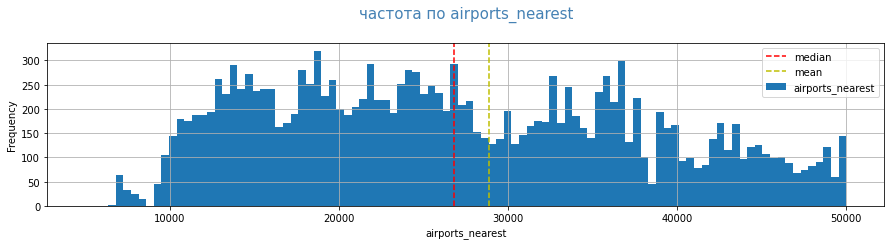

In [162]:
plot_with_range(data.query('airports_nearest != -1'),'airports_nearest',bins=100,range=(5000,50000))

Большой пласт квартир находится в ~10-50 км от аэропорта

___

Вывод:

##### Расстояние до ближайшего парка - parks_nearest

count    7729.000000
mean      492.024453
std       340.091769
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64


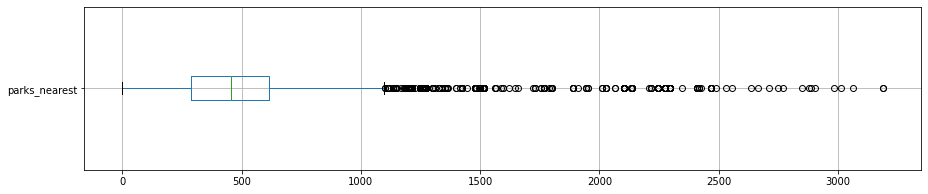

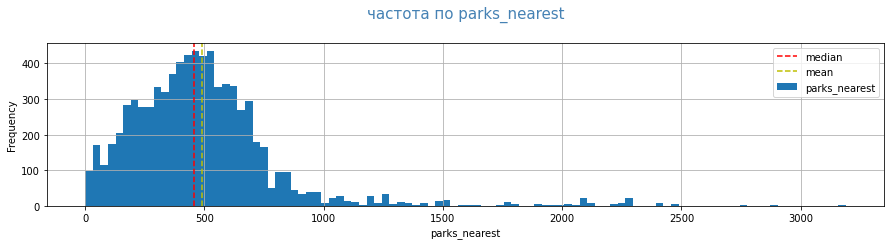

In [163]:
plot_info(data.query('parks_nearest != -1'),'parks_nearest',bins=100)

In [164]:
data.query('parks_nearest != -1 and parks_nearest < 900').shape[0] / data.shape[0] * 100

31.7420032380869

___

Вывод:

Ленинградская область богата на парки. 32% квартир продаются менее чем в 900 метрах от ближайшего парка

##### День недели выставления объявления - day_of_exposition

count    22853.000000
mean         2.568372
std          1.789099
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_of_exposition, dtype: float64


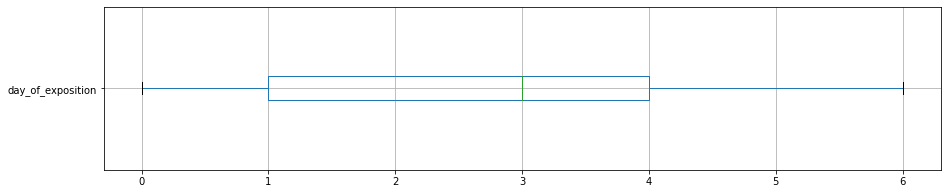

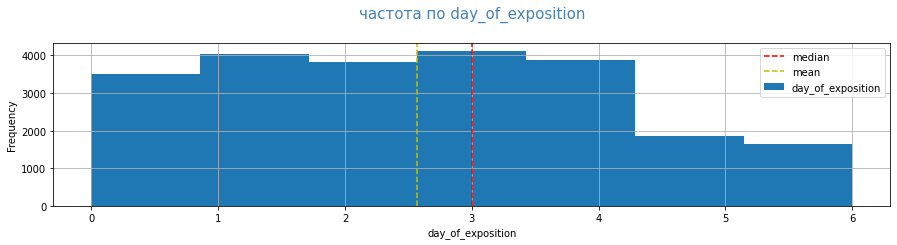

In [165]:
plot_info(data,'day_of_exposition',bins=7)

___

Вывод:

Обычно люди выставляютобъявления в будние дни

##### Месяц выставления объявления - month_of_exposition

count    22853.000000
mean         6.401129
std          3.485158
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_of_exposition, dtype: float64


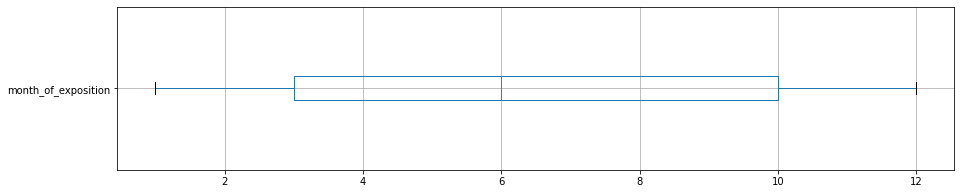

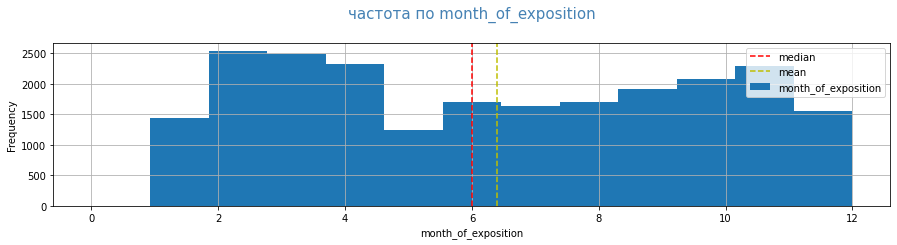

In [166]:
plot_info(data,'month_of_exposition',bins=13)

___

Вывод:

Судя по данным яндекса, самыми популярными месяцами для выставления квартиры на продажу являются февраль, март, апрель и ноябрь

___

**Общий вывод по рассмотренным переменным:**

<div style="border:solid blue 2px; padding: 20px">     

- преобладают квартиры с площадью ~$27-47 м^{2}$
- жилая площадь коррелирует с общей, но есть увеличение квартир в районе $18 м^{2}$ и $30  м^{2}$
- часто встречаются кухни одинаковой площади, независимо от общей площади. Это означает некоторую стандартизацию площади кухни
- распределение цены похоже на пуассоновское с пиком в районе 4млн
- Преобладают квартиры с 1ой, 2мя и 3мя комнатами, они составляют 93% всех квартир
- Много квартир с похожей высотой потолков(стандартная высота), но так же есть нетиповая застройка и старые здания
- В продаже преобладают квартиры с 1 по 5 этажи
- В продаже преобладают квартиры из 5 и 9 этажных домов
- В продаже преобладают квартиры удаленные на 10-18 км от центра
- Есть большой пласт квартир, находящихся в 10-40 км от аэропорта
- у 32% квартир менее чем в 900 метрах находится парк
- Чаще всего, люди выставляют объявления в будни
- Чаще всего, объявления выставляют в феврале, марте, апреле и ноябре



#### Как быстро продаются квартиры

count    22853.000000
mean       143.782042
std        182.712048
min         -1.000000
25%         22.000000
50%         71.000000
75%        190.000000
max        999.000000
Name: days_exposition, dtype: float64


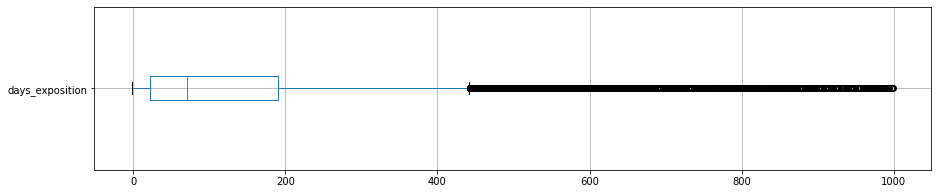

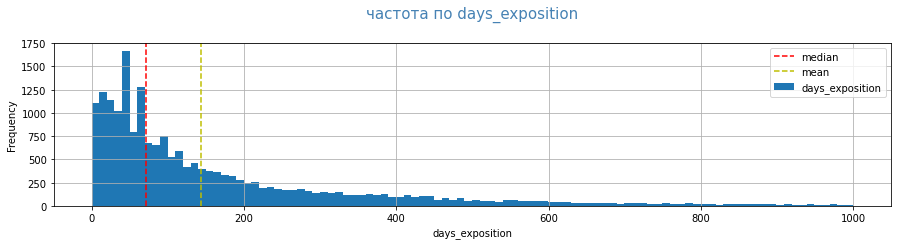

In [167]:
plot_info(data,'days_exposition', bins=100)

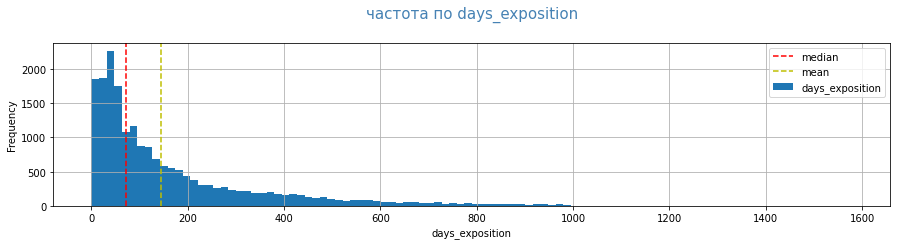

In [168]:
plot_with_range(data,'days_exposition',bins=100,range=(0,1580))

Посмотрим на рспределение квартир,которые еще продаются

In [169]:
date = data['first_day_exposition'].max()
def dif_date(val):
    return (pd.to_datetime(date)-val).days

In [170]:
data.query('days_exposition == -1')['first_day_exposition'].apply(dif_date).describe()

count    3080.000000
mean      214.066234
std       301.301676
min         0.000000
25%        30.000000
50%        80.000000
75%       273.000000
max      1618.000000
Name: first_day_exposition, dtype: float64

<AxesSubplot:>

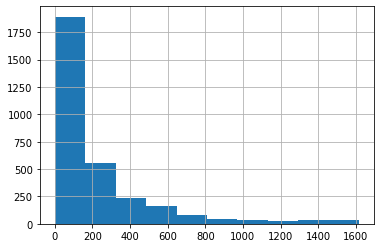

In [171]:
data.query('days_exposition == -1')['first_day_exposition'].apply(dif_date).hist()

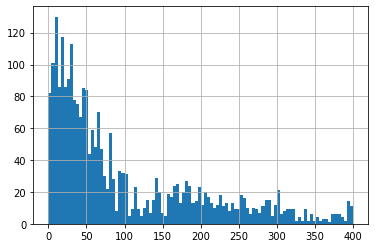

In [172]:
data.query('days_exposition == -1')['first_day_exposition'].apply(dif_date).hist(bins=100,range=(0,400));

Если взглянуть на два графика непроданных квартир, можно заметить преобладание в первые 50 дней. То есть, после прошествия 50-100 дней можно считать, что квартира продается долго.

Для точности примем границу равной 70.

Вернемся к проданным квартирам

In [173]:
data.query('days_exposition != -1')['days_exposition'].describe()

count    19773.000000
mean       166.334446
std        186.574598
min          1.000000
25%         44.000000
50%         93.000000
75%        219.000000
max        999.000000
Name: days_exposition, dtype: float64

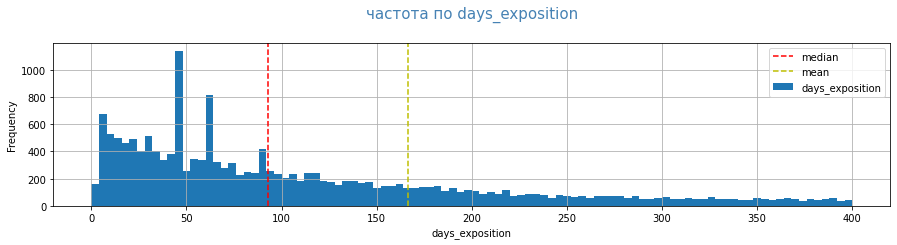

In [174]:
plot_with_range(data.query('days_exposition != -1'),'days_exposition',bins=100,range=(0,400))

По данному графику сложно сказать, когда можно считать, что квартира продается долго или быстро.

Так же видны необычные всплески,которые сложно объяснить. Первое предположение было связано с продажей квартиры после проществия 40 дней после смерти, но оно не совсем логично ( тк тогда бы люди выставляли. на продажу через 40 дней, а не именно продавали)

Тогда можно сравнить со сроками размещения объявления в ЛенОбласти. Оно составляет 30, 90 и 120 дней, что так же не коррелирует с графиком. Так что точного ответа нет

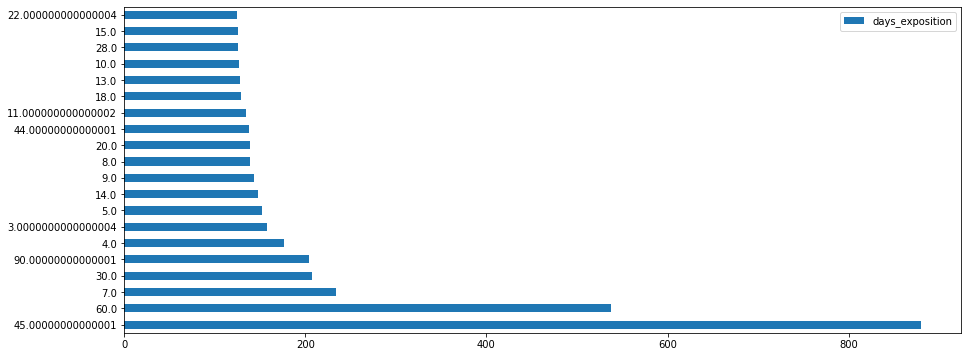

In [175]:
# check
# Моды на реальных данных
     
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

Посмотрим на квантили

In [176]:
data.query('days_exposition != -1')['days_exposition'].describe()

count    19773.000000
mean       166.334446
std        186.574598
min          1.000000
25%         44.000000
50%         93.000000
75%        219.000000
max        999.000000
Name: days_exposition, dtype: float64

Посмотрим на распределение скорости продажи квартир по годам

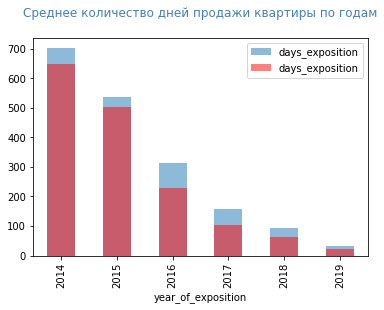

In [177]:
ax = data.query('days_exposition != -1')\
    .pivot_table(index='year_of_exposition',values='days_exposition',aggfunc='mean').plot.bar(alpha=0.5)
data.query('days_exposition != -1')\
    .pivot_table(index='year_of_exposition',values='days_exposition',aggfunc='median')\
    .plot.bar(ax=ax,color='r',alpha=0.5);
ax.set_title('Среднее количество дней продажи квартиры по годам\n', color = 'SteelBlue');

На графике отображено среднее количество дней по годам, за которое продавались квартиры.

Видно, что с прошествием лет, количество дней сильно падает. Скорее всего это связано с ростом популярности сервиса продажи квартир со стороны покупателей

___

Вывод:

<div style="border:solid blue 2px; padding: 20px">     
В среднем, продажа занимает 180 дней.

**медиана - 95**

**среднее - 180.7**

Но, основываясь на данных о непроданных квартирах, можно принять границу в **44** дней (до), как показатель, что квартира продается очень быстро, а **219**(после), что очень долго. 
</div>


#### Какие факторы влияют на полную стоимость квартиры

Будем рассматривать зависимость цены от:

- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год);

##### Зависимость от общей площади

In [178]:
data['total_area'].corr(data['last_price'])

0.7822756940379587

In [179]:
data['last_price_mln'] = data['last_price'] / 1000000

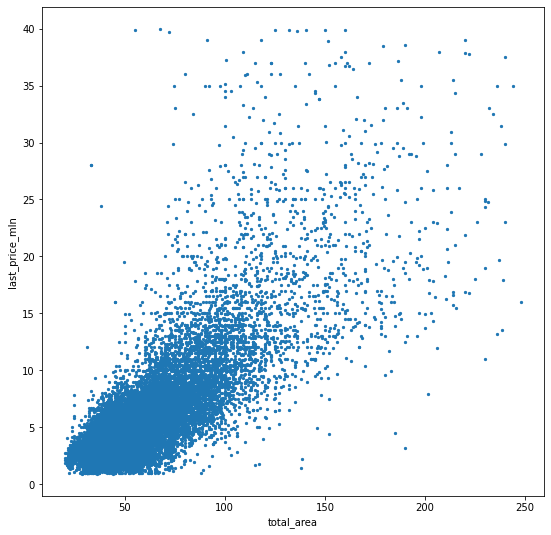

In [180]:
data.plot.scatter('total_area', 'last_price_mln', s=5,figsize=(9,9));

___

Вывод:

Видна явная зависимость цены от площади квартиры, однако есть выбивающиеся значения, цена которых обуславливается другими фактора. При увеличении цены/площади зависимость уменьшается

##### Зависимость от жилой площади

На первый взгляд сильной зависимости нет

In [181]:
data.query('living_area != -1')['living_area'].corr(data.query('living_area != -1')['last_price'])

0.6752589519201481

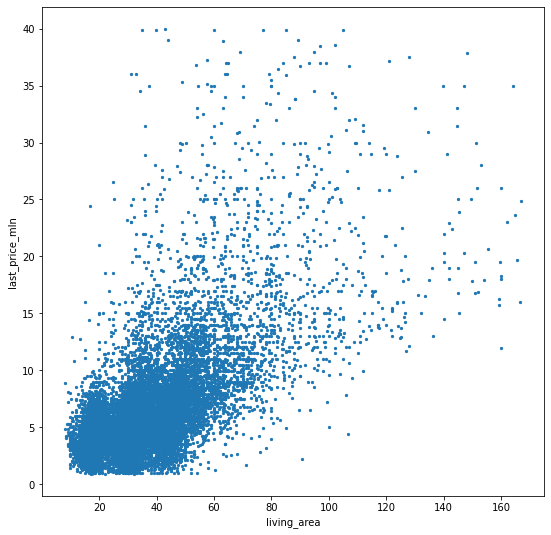

In [182]:
data.query('living_area != -1').plot.scatter('living_area', 'last_price_mln', s=5 ,figsize=(9,9));

___

Вывод:

у жилой площади так же есть зависимость с ценой, но не такая сильная как у общей площади, скорее всего, это связано с тем, что помимо жилой площади для многих покупателей так же важны другие помещения(кухня, коридоры, туалет, подсобные помещения)

##### Зависимость от площади кухни

In [183]:
data.query('kitchen_area != -1')['kitchen_area'].corr(data.query('kitchen_area != -1')['last_price'])

0.5946920654769237

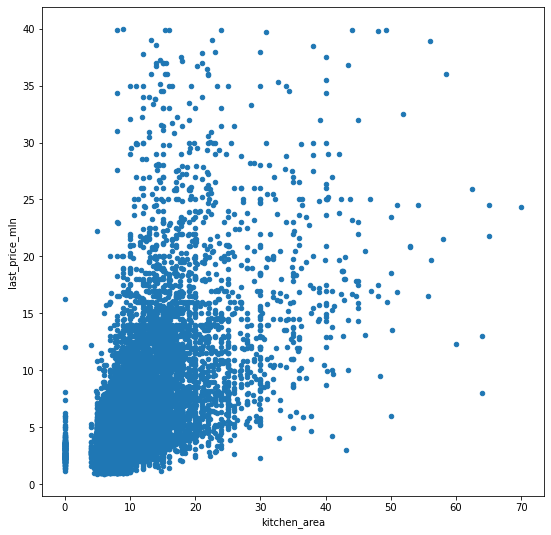

In [184]:
data.query('kitchen_area != -1').plot.scatter('kitchen_area', 'last_price_mln', figsize=(9,9));

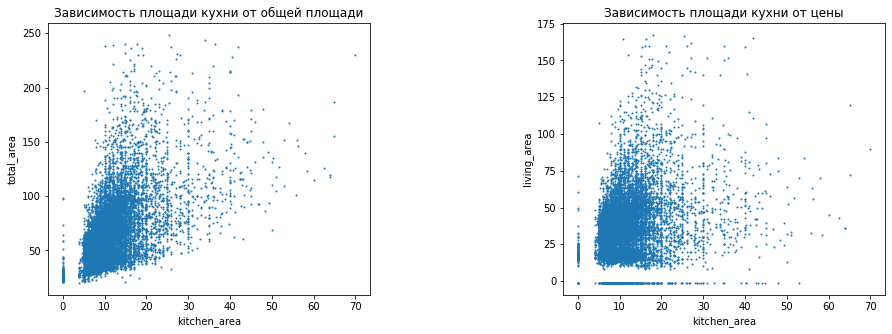

In [185]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5),gridspec_kw={'wspace': 0.6})
data.query('kitchen_area != -1').plot.scatter('kitchen_area', 'total_area', s=1,ax=axs[0]);
axs[0].set_title('Зависимость площади кухни от общей площади')
data.query('kitchen_area != -1').plot.scatter('kitchen_area', 'living_area',s=1,ax=axs[1]);
axs[1].set_title('Зависимость площади кухни от цены');

___

Вывод:

Сразу можно сказать, что итоговая цена зависит от площади кухни в разы меньше чем от общей или жилой площади.
Можно предположить, что это связано с стандартностью размеров самой кухни. Например, четкие вертикальный линии, которые так же присутствуют и на графике с зависимостью площади кухни и общей площади, скорее всего говорят о том, что при разной цене и при разной общей площади6 площадь кухни может совпадать, то есть площадь кухни - стандартизована во многих квартирах

##### Зависимость от количества комнат

In [186]:
data['rooms'].corr(data['last_price_mln'])

0.4971863264533542

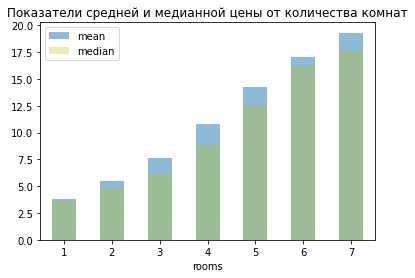

In [187]:
ax = (
    data
    .pivot_table(index='rooms',values='last_price_mln',aggfunc='mean')
    .rename(columns={'last_price_mln':'mean'})
    .plot.bar(alpha=0.5)
)
(
    data
    .pivot_table(index='rooms',values='last_price_mln',aggfunc='median')
    .rename(columns={'last_price_mln':'median'})
    .plot.bar(ax=ax,color='y',alpha=0.3,rot=0)
)
ax.set_title('Показатели средней и медианной цены от количества комнат');

Виднеется явная зависимость между количеством комнат и ценой. Но не такая сильная как с площадью

___

Вывод:

Графики очень точно совпадают, что настораживает.

Вероятнее всего, на цену больше влияет общая площадь квартиры, чем количество комнат. Предположение с комуналкой подходит, то есть, много маленьких комнат менее привлекательно для покупателя, чем несколько, но больших

##### Зависимость от типа этажа

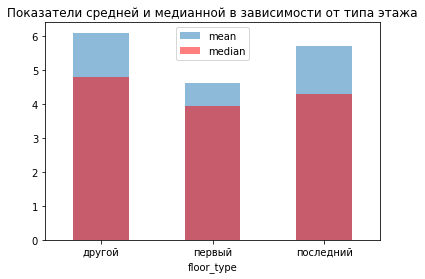

In [188]:
ax = (
    data.
    pivot_table(index='floor_type',values='last_price_mln',aggfunc='mean')
    .rename(columns={'last_price_mln':'mean'})
    .plot.bar(alpha=0.5, label='mean')
)
(
    data
    .pivot_table(index='floor_type',values='last_price_mln',aggfunc='median')
    .rename(columns={'last_price_mln':'median'})
    .plot.bar(ax=ax,color='r',alpha=0.5,label='median',rot=0)
)
ax.set_title('Показатели средней и медианной в зависимости от типа этажа');

___

Вывод:

Основываясь на графике, можно заявить, что чаще всего, квартиры на первом и последнем этажах дешевле(причем первый уступает)

##### Зависимость от дня,  месяца, года

Text(0.5, 1.0, 'Зависимость цены от дня публикации')

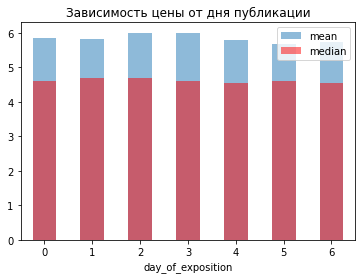

In [189]:
ax = (
    data
    .pivot_table(index='day_of_exposition',values='last_price_mln',aggfunc='mean')
    .rename(columns={'last_price_mln':'mean'})
    .plot.bar(alpha=0.5)
)
(data
 .pivot_table(index='day_of_exposition',values='last_price_mln',aggfunc='median')
 .rename(columns={'last_price_mln':'median'})
 .plot.bar(ax=ax,color='r',alpha=0.5,rot=0)
);
ax.set_title('Зависимость цены от дня публикации')

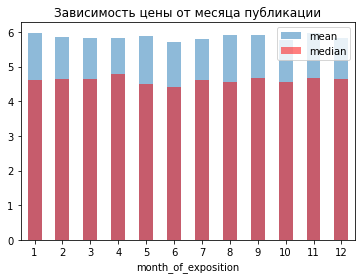

In [190]:
ax = (
    data
    .pivot_table(index='month_of_exposition',values='last_price_mln',aggfunc='mean')
    .rename(columns={'last_price_mln':'mean'})
    .plot.bar(alpha=0.5)
)
(data
 .pivot_table(index='month_of_exposition',values='last_price_mln',aggfunc='median')
 .rename(columns={'last_price_mln':'median'})
    .plot.bar(ax=ax,color='r',alpha=0.5,rot=0)
)
ax.set_title('Зависимость цены от месяца публикации');

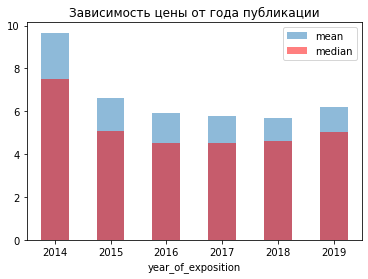

In [191]:
ax = (
    data
    .pivot_table(index='year_of_exposition',values='last_price_mln',aggfunc='mean')
    .rename(columns={'last_price_mln':'mean'})
    .plot.bar(alpha=0.5)
)
(data
 .pivot_table(index='year_of_exposition',values='last_price_mln',aggfunc='median')
 .rename(columns={'last_price_mln':'median'})
    .plot.bar(ax=ax,color='r',alpha=0.5,rot=0)
)
ax.set_title('Зависимость цены от года публикации');

Подробнее рассмотрим зависимость цены от года публикации. Почему в 2014 году средние цены на квартиры были выше? Или просто продавались чаще дорогие квартиры

Посмотрим как менялась средняя площадь квартир по годам, а так же количество объявлений

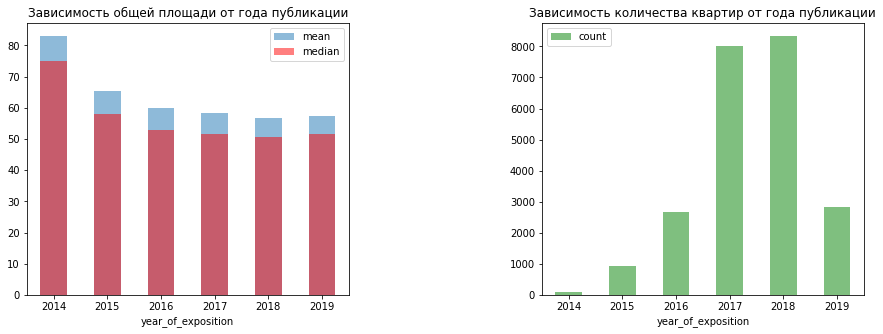

In [192]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5),gridspec_kw={'wspace': 0.6})
(
    data
    .pivot_table(index='year_of_exposition',values='total_area',aggfunc='mean')
    .rename(columns={'total_area':'mean'})
    .plot.bar(alpha=0.5,ax=ax[0])
)
(data
    .pivot_table(index='year_of_exposition',values='total_area',aggfunc='median')
    .rename(columns={'total_area':'median'})
    .plot.bar(alpha=0.5,color='r',rot=0,ax=ax[0])
)
(data
    .pivot_table(index='year_of_exposition',values='total_area',aggfunc='count')
    .rename(columns={'total_area':'count'})
    .plot.bar(alpha=0.5,color='g',rot=0,ax=ax[1])
)

ax[0].set_title('Зависимость общей площади от года публикации');
ax[1].set_title('Зависимость количества квартир от года публикации');

Взглянем на сводную таблицу по last_price_mln в зависимости от года

In [193]:
check_by_last_price_mln = (data
 .pivot_table(index='year_of_exposition',values='last_price_mln',aggfunc=['count','max','min','median','mean'])
 
)
check_by_last_price_mln.columns = ['count','max','min','median','mean']
check_by_last_price_mln

,count,max,min,median,mean
year_of_exposition,,,,,
2014,84,29.99900,1.300,7.48828,9.664921
2015,937,39.99000,0.995,5.10000,6.622945
2016,2669,39.90000,0.920,4.50000,5.925962
2017,8015,39.90000,0.950,4.50000,5.775219
2018,8333,39.77328,0.910,4.60000,5.673176
2019,2815,39.90000,0.950,5.05000,6.201820


Взглянем на сводную таблицу по total_area в зависимости от года

In [194]:
check_by_total_area = (data
 .pivot_table(index='year_of_exposition',values='total_area',aggfunc=['count','max','min','median','mean'])
 
)
check_by_total_area.columns = ['count','max','min','median','mean']
check_by_total_area

,count,max,min,median,mean
year_of_exposition,,,,,
2014,84,190.00,31.00,75.015,83.000119
2015,937,240.00,20.67,58.000,65.378943
2016,2669,244.00,20.50,53.000,59.995605
2017,8015,248.00,21.00,51.700,58.444331
2018,8333,237.00,20.30,50.600,56.751064
2019,2815,238.26,20.10,51.700,57.414316


2014 год выбивается из-за того, что основное количество квартир составляли квартиры с большой стоимостью.

Взглянем на распределение средней стоимости квадратного метра по годам

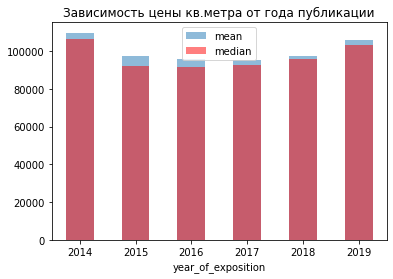

In [195]:

ax = (
    data
    .pivot_table(index='year_of_exposition',values='price_per_area',aggfunc='mean')
    .rename(columns={'price_per_area':'mean'})
    .plot.bar(alpha=0.5)
)
(data
 .pivot_table(index='year_of_exposition',values='price_per_area',aggfunc='median')
 .rename(columns={'price_per_area':'median'})
    .plot.bar(ax=ax,color='r',alpha=0.5,rot=0)
)
ax.set_title('Зависимость цены кв.метра от года публикации');

2014 все так же выбивается. Посмотрим на него подробнее

In [196]:
year_2014 = data.query('year_of_exposition == 2014')

In [197]:
year_2014['price_per_area'].describe()

count        84.000000
mean     109587.343994
std       39278.386723
min       24667.931689
25%       80762.435847
50%      106406.451872
75%      140354.721788
max      224711.610487
Name: price_per_area, dtype: float64

In [198]:
price_per_area_by_year = (data
 .pivot_table(index='year_of_exposition',values='price_per_area',aggfunc=['median','mean'])
 
)
price_per_area_by_year.columns = ['median','mean']
price_per_area_by_year.style.format("{:,.0f}")

,median,mean
year_of_exposition,,
2014,"106,406","109,587"
2015,"91,860","97,460"
2016,"91,601","95,655"
2017,"92,419","95,432"
2018,"95,833","97,417"
2019,"103,368","105,562"


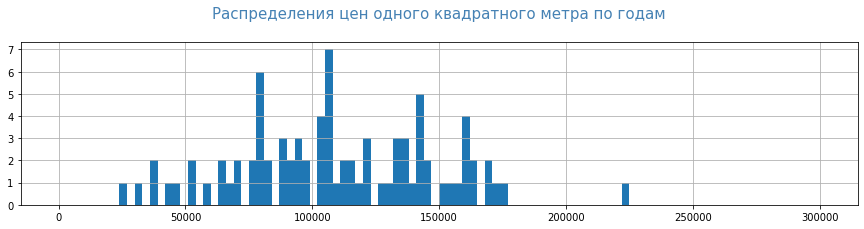

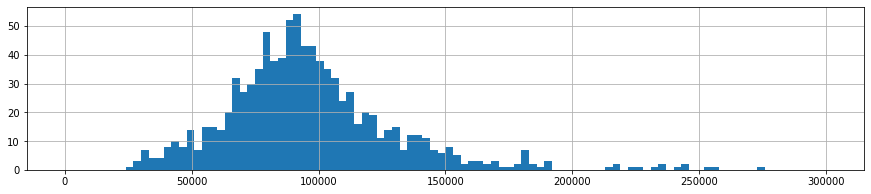

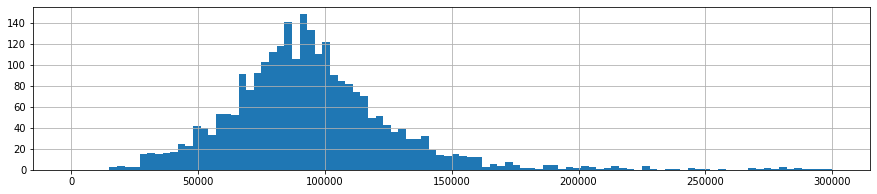

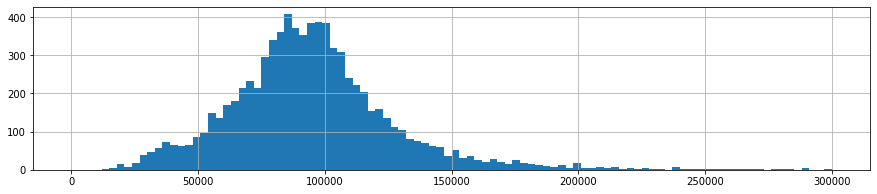

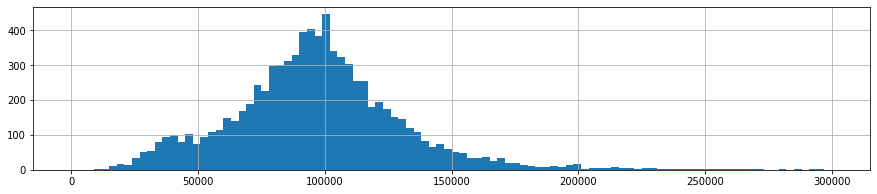

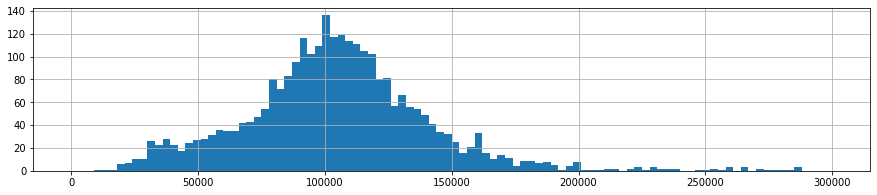

In [199]:
for year in range(2014,2020):
    ax = data.query('year_of_exposition == @year')['price_per_area'].hist(bins=100,figsize=(15,3),range=(0,300000));
    if year == 2014:
        ax.set_title('Распределения цен одного квадратного метра по годам\n', fontsize = 15, color = 'SteelBlue');
    plt.show()

Видно, что средняя и медианная цена за один квадратный метр в 2014 выше чем в последующих. Это связано с тем, что в 2014 всего было 84 объявления, и многие из них с завышенной ценой за метр квадратный

In [200]:
price_per_area_by_year['percent'] = price_per_area_by_year['mean'].shift(1)

price_per_area_by_year['percent'] =(1 - price_per_area_by_year['percent']/price_per_area_by_year['mean']) * 100
price_per_area_by_year.style.format("{:,.2f}")

,median,mean,percent
year_of_exposition,,,
2014,"106,406.45","109,587.34",nan
2015,"91,860.47","97,459.90",-12.44
2016,"91,601.05","95,654.81",-1.89
2017,"92,418.77","95,431.91",-0.23
2018,"95,833.33","97,416.98",2.04
2019,"103,367.88","105,562.26",7.72


Если не рассматривать 2014 и 2015 года6 из-за нерепрезентативности6 можно считать, что средняя цена одного квадратного метра растет

___

Вывод:

Основываясь на графиках, можно сделать вывод, что зависимости от дней и месяцев нет, но от года в год средняя цены меняется (в 2014 самая большая)

Если взглянуть на приведенные графики и сводные таблицы, показывающие изменение цен и общей площади по годам, можно заметить, что в 2014
было всего 84 объявления, с высокой средней площадью квартир. Это значит, что 2014 году было мало объявлений и у большинства квартир была большая площадь из чего следует их высокая стоимость, что в свою очередь ведет к повышению средней стоимости за год. Так же, оказалось, что в 2014 году увеличена средняя цена одного квадратного метра из-за малого количества объявлений и большого количества предложений по завышенной цене.

В 2015 году ситуация схожая, но объявлений уже больше, средняя площадь ниже чем в 2014, но все равно средняя цена выше чем в остальные года.

Основываясь на этом, нельзя сказать, что средняя цена в 2014 была выше, так как количество объявлений за этот год нерепрезентативно.

Если смотреть на другие года, то средняя цена квадратного метра немного растет к 2019 году

___

**Общий вывод по зависимости цены:**

<div style="border:solid blue 2px; padding: 20px"> 
  
Проведя анализ зависимости итоговой цены от таких параметров, как:
    
    - общая площадь
    
    - жилая площадь
    
    - площадь кухни
    
    - количество комнат
    
    - тип этажа
    
    - день, месяц, год выставления объявления

можно сделать следующие выводы:
    
    - цена сильно зависит от общей площади и в меньшей степени от жилой площади. Меньшее влияние жилой площади связано с тем, что этот параметр не отражает наличие еще какой-либо площади (туалеты, коридоры, кухня и тд), которая учитывается в общей площади квартиры.
    
    - цена слабо зависит от площади кухни. Это опять же связано с тем, что этот параметр не отражает наличие другой площади, а так же размер кухни зачастую стандартизирован и не сильно меняется от квартиры к квартире
    
    - есть прямая зависимость между количеством комнат и ценой. Но не такая сильная как с общей площадью
    
    - первый и последние этажи дешевле остальных
    
    - день и месяц не влияют на ценообразование
    
    - цена квадратного метра немного растет к 2019 года (не рассматриваем 2014 и 2015 года из-за нерепрезентативных данных)
</div>


####  Рассмотрим цену одного квадратного метра в разных населенных пунктах

Создадим отсортированную сводную таблицу и сохраним первые 10 значений

In [201]:
target_locality_name = (
    data
    .pivot_table(index='locality_name',values='last_price_mln',aggfunc='count')
    .sort_values(by='last_price_mln',ascending=False)
    .head(10)
)
target_locality_name.columns = ['count']
target_locality_name


,count
locality_name,
санкт-петербург,15204
поселок мурино,547
поселок шушары,434
всеволожск,392
пушкин,359
колпино,335
поселок парголово,326
гатчина,306
деревня кудрово,293


По предыдущей сводной таблице построим новую, содержащую среднюю и медианную цену за один квадратный метр

In [202]:
target_mean_price = (
    data
    .query('locality_name in @target_locality_name.index')
    .pivot_table(index='locality_name', values='price_per_area',aggfunc=['mean','median'])
)
target_mean_price.columns = ['mean','median']
target_mean_price = target_mean_price.sort_values(by='mean')
target_mean_price.style.format("{:,.0f}")

,mean,median
locality_name,,
выборг,"58,535","58,357"
всеволожск,"68,794","65,789"
гатчина,"68,935","67,861"
колпино,"75,280","74,658"
поселок шушары,"78,466","76,667"
поселок мурино,"85,684","86,043"
поселок парголово,"90,103","91,580"
деревня кудрово,"92,430","91,803"
пушкин,"103,189","100,000"


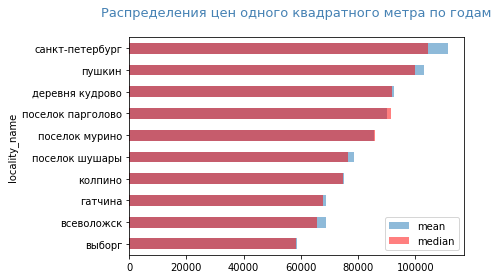

In [203]:
ax = target_mean_price.plot(kind = 'barh',y='mean',alpha=0.5)
target_mean_price.plot(kind = 'barh',y='median',ax=ax,color='r',alpha=0.5);
ax.set_title('Распределения цен одного квадратного метра по годам\n', fontsize = 13, color = 'SteelBlue');
# for rect in ax.containers[0].patches:
#     height = rect.get_height()
#     ax.annotate('{:.2f}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), ha='center', va='bottom')


___

Вывод:

<div style="border:solid blue 2px; padding: 20px"> 
Санкт-петербург и Пушкин города с самой высокой ценой за один квадратный метр:
    
    СПБ - 109599 р/м2
    
    Пушкин - 102152 p/м2
    
Города с самой низкой стоимостью квадратного метра:
    
    Выборг - 58142 р/м2
    
    Всеволожск - 68654 р/м2
    
    Гатчина - 68746 р/м2
</div>

#### Стоимость одного километра до центра - СПБ

In [204]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_exposition,month_of_exposition,year_of_exposition,floor_type,cityCenters_nearest_km,last_price_mln
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,unknown,False,False,25.0,0,санкт-петербург,18863,16028,1,482,2,755,-1,120370.370370,3,3,2019,другой,16,13.000
1,7,3350000.0,40.4,2018-12-04,1,-1.00,11,18.6,1,unknown,False,False,11.0,2,поселок шушары,12817,18603,0,-1,0,-1,81,82920.792079,1,12,2018,первый,19,3.350
2,10,5196000.0,56.0,2015-08-20,2,-1.00,5,34.3,4,unknown,False,False,8.3,0,санкт-петербург,21741,13933,1,90,2,574,558,92785.714286,3,8,2015,другой,14,5.196
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,unknown,False,False,41.0,0,санкт-петербург,31856,8098,2,112,1,48,121,100000.000000,1,6,2018,другой,8,10.000
5,10,2890000.0,30.4,2018-09-10,1,-1.00,12,14.4,5,unknown,False,False,9.1,0,городской поселок янино-1,-1,-1,0,-1,0,-1,55,95065.789474,0,9,2018,другой,-1,2.890


In [205]:
spb_km = data.query('cityCenters_nearest_km != -1 and locality_name == "санкт-петербург"')

In [206]:
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='last_price_mln',aggfunc='mean')
.style.format("{:,.0f}")
)

,last_price_mln
cityCenters_nearest_km,
0,16
1,12
2,12
3,10
4,11
5,11
6,10
7,11
8,9


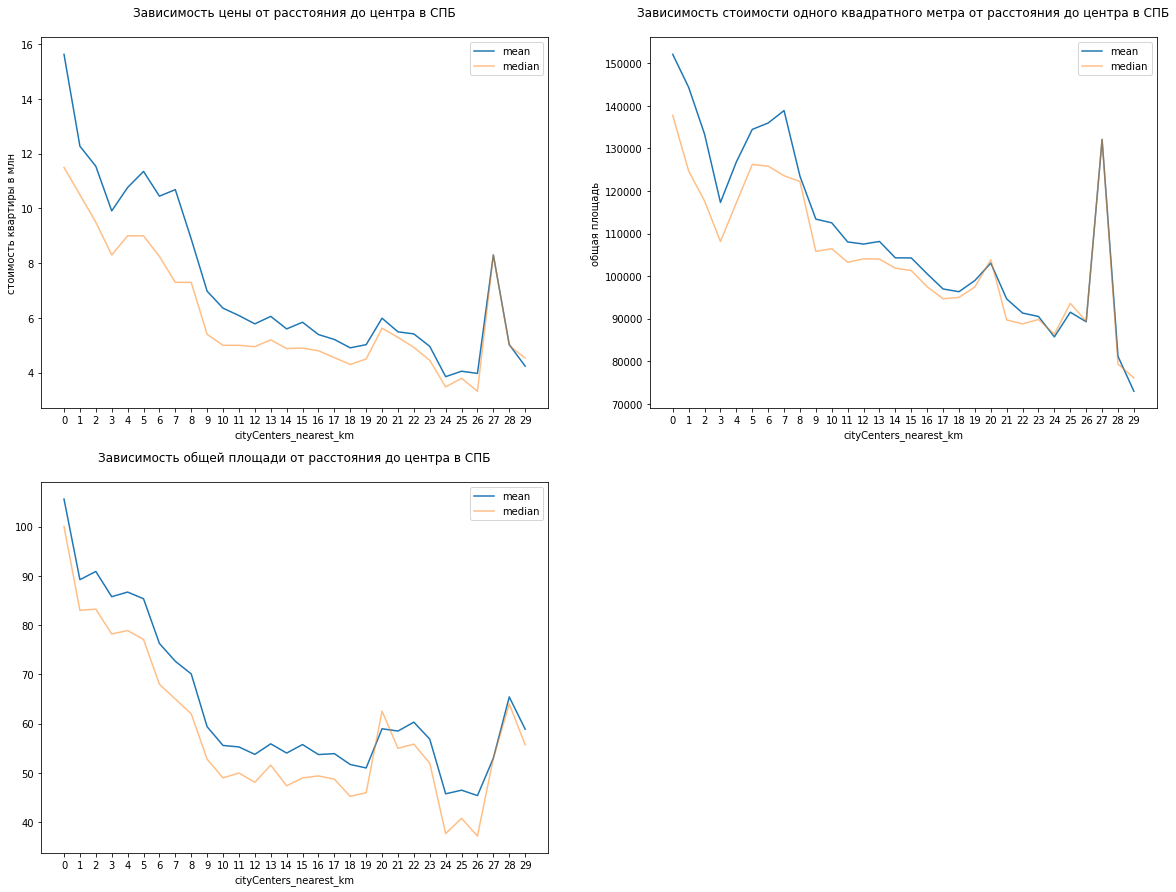

In [207]:
fig, ax = plt.subplots(2,2, figsize=(20,15),gridspec_kw={'wspace': 0.2})
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='last_price_mln',aggfunc='mean')
.reset_index()
.rename(columns={'last_price_mln':'mean'})
.plot.line('cityCenters_nearest_km','mean',ax=ax[0,0])
)
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='last_price_mln',aggfunc='median')
.reset_index()
.rename(columns={'last_price_mln':'median'})
.plot.line('cityCenters_nearest_km','median',ax=ax[0,0],alpha=0.5)
)
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='price_per_area',aggfunc='mean')
.reset_index()
.rename(columns={'price_per_area':'mean'})
.plot.line('cityCenters_nearest_km','mean',ax=ax[0,1])
)
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='price_per_area',aggfunc='median')
.reset_index()
.rename(columns={'price_per_area':'median'})
.plot.line('cityCenters_nearest_km','median',ax=ax[0,1],alpha=0.5)
)
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='total_area',aggfunc='mean')
.reset_index()
.rename(columns={'total_area':'mean'})
.plot.line('cityCenters_nearest_km','mean',ax=ax[1,0])
)
(spb_km
.pivot_table(index='cityCenters_nearest_km',values='total_area',aggfunc='median')
.reset_index()
.rename(columns={'total_area':'median'})
.plot.line('cityCenters_nearest_km','median',alpha=0.5,ax=ax[1,0])
)

ax[0,0].set_xticks(range(0, 30, 1))
ax[1,0].set_xticks(range(0, 30, 1))
ax[0,1].set_xticks(range(0, 30, 1))
ax[0,0].set_title('Зависимость цены от расстояния до центра в СПБ\n');
ax[0,0].set_ylabel('стоимость квартиры в млн', fontsize = 10) 
ax[0,1].set_title('Зависимость стоимости одного квадратного метра от расстояния до центра в СПБ\n');
ax[0,1].set_ylabel('стоимость кв метра', fontsize = 10);
ax[1,0].set_title('Зависимость общей площади от расстояния до центра в СПБ\n');
ax[0,1].set_ylabel('общая площадь', fontsize = 10);
fig.delaxes(ax[1, 1])
plt.subplots_adjust(hspace=0.2, wspace=0.1)

Заметим, что пики на 3, 20 и 27 километрах на графике "Заивисмость цены" так же прослеживаются и на графике "Зависимость стоимости одного кв метра", а на графике "Зависимость общей площади" их нет. Можно сделать вывод, что на 3км стоимость кв метра снижена, а на 20 и 27км - завышена. То есть цена не соотвествует тенденции снижения относительно отдаления от центра как раз из-за несоотвествия средней стоимости кв метра.



Взглянем на количество объявлений по километрам

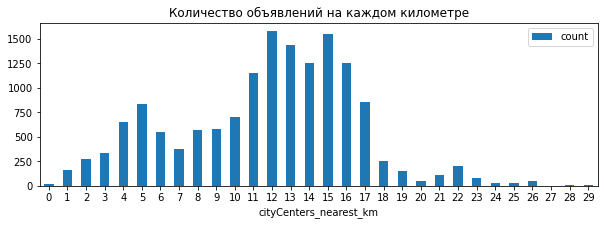

In [208]:
ax = (spb_km
.pivot_table(index='cityCenters_nearest_km',values='total_area',aggfunc='count')
.reset_index()
.rename(columns={'total_area':'count'})
.plot.bar('cityCenters_nearest_km','count',rot=0,figsize=(10,3))
)
ax.set_title('Количество объявлений на каждом километре');

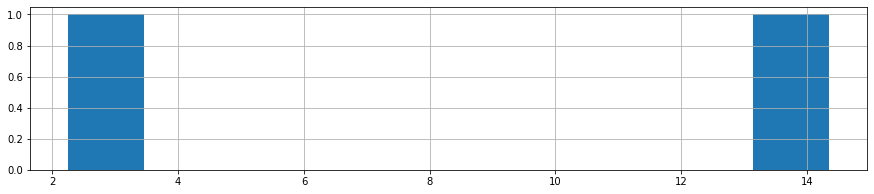

In [209]:
spb_km.query('cityCenters_nearest_km == 27')['last_price_mln'].hist(figsize=(15,3));

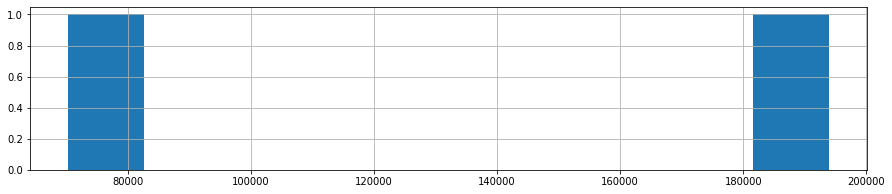

In [210]:
spb_km.query('cityCenters_nearest_km == 27')['price_per_area'].hist(figsize=(15,3));

In [211]:
spb_km.query('cityCenters_nearest_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_area,day_of_exposition,month_of_exposition,year_of_exposition,floor_type,cityCenters_nearest_km,last_price_mln
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,unknown,False,False,25.0,0,санкт-петербург,23888,27313,1,1496,0,-1,128,193918.918919,1,11,2017,другой,27,14.35
5961,6,2250000.0,32.0,2018-02-27,1,-1.00,2,16.5,2,unknown,False,False,7.0,0,санкт-петербург,24006,27431,0,-1,0,-1,178,70312.500000,1,2,2018,последний,27,2.25


На 27 километре всего 2 объявления и одно из них почти в 7 раз дороже другого, а его средняя цена кв метра в 3 раза дороже. Из-за этого и виднеется выброс на 27км

Взглянем на соотношенией типа этажа по километрам

In [212]:
data_floor_type = {'первый': [],
                    'другой': [],
                    'последний': []}
for km in range(30):
    for floor_type in spb_km['floor_type'].unique():
        parts = (
            spb_km.query('cityCenters_nearest_km == @km and floor_type == @floor_type').shape[0]
            / spb_km.query('cityCenters_nearest_km == @km').shape[0]
        )
        data_floor_type[floor_type].append(parts)

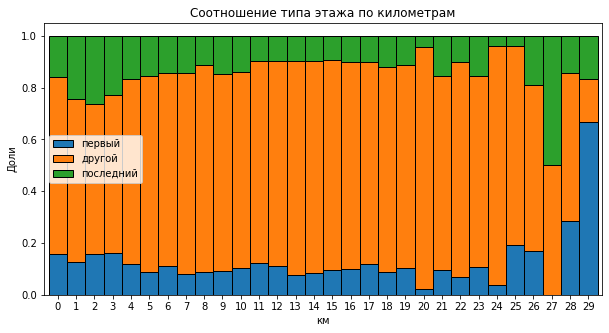

In [213]:
df = pd.DataFrame(data_floor_type)
ax = df.plot.bar(stacked=True, width=1,rot=0,figsize=(10,5),edgecolor='black')
ax.set_title('Соотношение типа этажа по километрам');
ax.set_ylabel('Доли');
ax.set_xlabel('км');

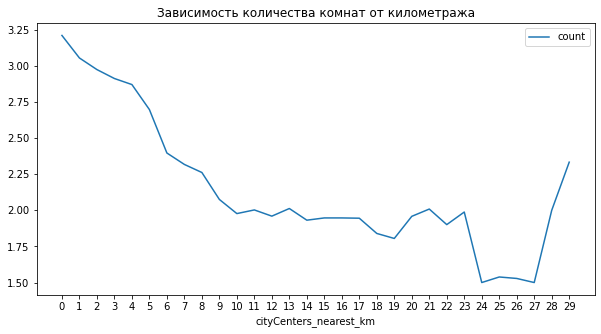

In [214]:
ax = (spb_km
.pivot_table(index='cityCenters_nearest_km',values='rooms',aggfunc='mean')
.reset_index()
.rename(columns={'rooms':'count'})
.plot.line('cityCenters_nearest_km','count',rot=0,figsize=(10,5))
)
ax.set_xticks(range(0, 30, 1))
ax.set_title('Зависимость количества комнат от километража');

Количество комнат уменьшается с отдаленией от центра и не влияет на появление пиков на 3 и 27 км, учитывая, что с увеличением комнат увеличивается цена

___

Вывод:

<div style="border:solid blue 2px; padding: 20px"> 
Было выяснено, что с отдалением от центра цена квартир уменьшается.
 
Так же были найдены выбросы на 3, 20 и 27 км, которые появляются из-за заниженной цены на кв метр (3 км) и из-за завышенной (20,27 км)


### Общий вывод

Было проведено исследование объявлений о продаже квартир в Ленинградской области.

**Этап предобработки:**

* было найдено и удалено много пропусков 

* были найдены и удалены аномалии

* были заменены типы данных

**Исследовательский анализ данных**
 
* были исследованы некоторые переменные и получены следующие выводы:
    
    - преобладают квартиры с площадью ~$27-47 м^{2}$
    - жилая площадь коррелирует с общей, но есть увеличение квартир в районе $18 м^{2}$ и $30  м^{2}$
    - часто встречаются кухни одинаковой площади, независимо от общей площади. Это означает некоторую стандартизацию площади кухни
    - распределение цены похоже на пуассоновское с пиком в районе 4млн
    - Преобладают квартиры с 1ой, 2мя и 3мя комнатами, они составляют 93% всех квартир
    - Много квартир с похожей высотой потолков(стандартная высота), но так же есть нетиповая застройка и старые здания
    - В продаже преобладают квартиры с 1 по 5 этажи
    - В продаже преобладают квартиры из 5 и 9 этажных домов
    - В продаже преобладают квартиры удаленные на 10-18 км от центра
    - Есть большой пласт квартир, находящихся в 10-40 км от аэропорта
    - у 32% квартир менее чем в 900 метрах находится парк
    - Чаще всего, люди выставляют объявления в будни
    - Чаще всего, объявления выставляют в феврале, марте, апреле и ноябре
    
<p>
</p>
    
* была исследована зависимость цены от неккоторых переменных и получены следующие выводы:
    - цена сильно зависит от общей площади и в меньшей степени от жилой площади. Меньшее влияние жилой площади связано с тем, что этот параметр не отражает наличие еще какой-либо площади (туалеты, коридоры, кухня и тд), которая учитывается в общей площади квартиры.
    
    - цена слабо зависит от площади кухни. Это опять же связано с тем, что этот параметр не отражает наличие другой площади, а так же размер кухни зачастую стандартизирован и не сильно меняется от квартиры к квартире
    
    - есть прямая зависимость между количеством комнат и ценой. Но не такая сильная как с общей площадью
    
    - первый и последние этажи дешевле остальных
    
    - день и месяц не влияют на ценообразование
    
    - цена квадратного метра немного растет к 2019 года (не рассматриваем 2014 и 2015 года из-за нерепрезентативных данных)
    
<p>
</p>

* Был изучен вопрос "Как быстро продаются квартиры". Было выяснено, что примерно граница "до 44 дней" - квартира продалась очень быстро, а "после 219 дней" - очень долго
    
<p>
</p>
    
* Было изучено влияние некоторых переменных на стоимость квартир. Особое внимание стоит уделить общей площади, количеству комнат и типу этажа.
    
<p>
</p>
    
* Была посчитана средняя цена в 10 населенных пунктах с самым большим числом объявлений:
    - СПБ и Пушкин - самая высокая стоимость кв метра
    
    - Выборг, Всеволожск, Гатчина - самая низкая
        
<p>
</p>
    
* Была посчитана средняя стоимость квартир на каждом километре и выяснено, что с отдалением цена уменьшается, но на некоторых километрах есть выбросы, связанные с завышенной или заниженной стоимостью за кв метр

### Бонус

In [216]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

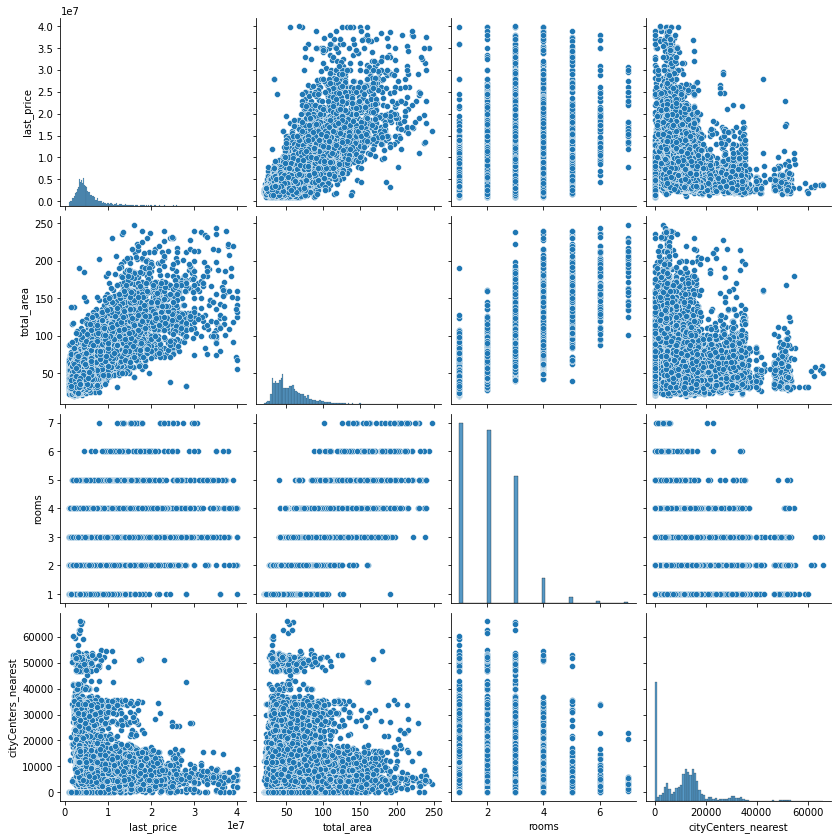

In [217]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


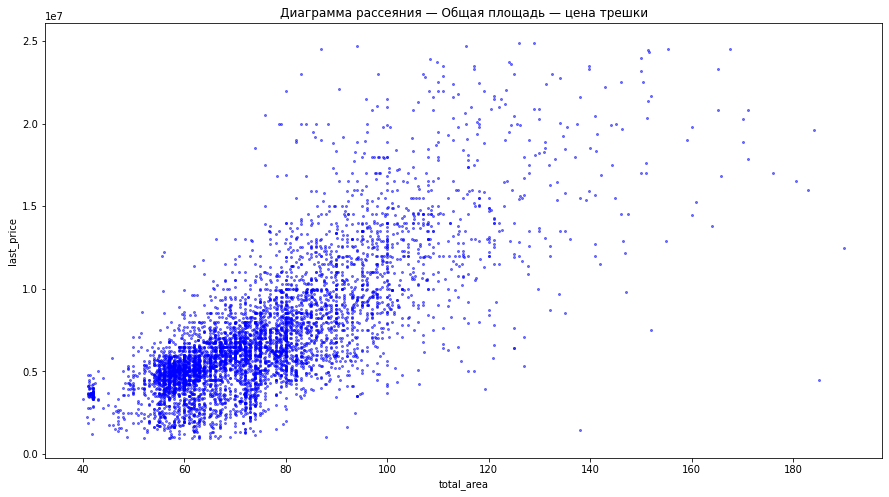

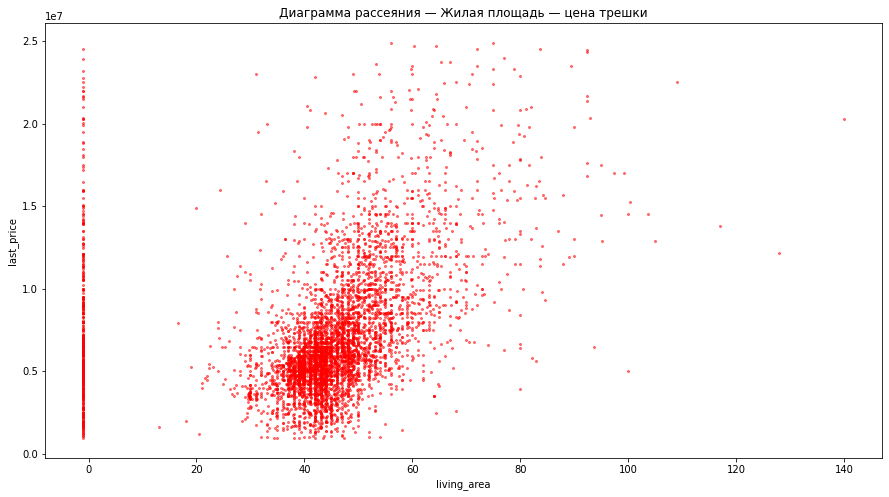

In [218]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

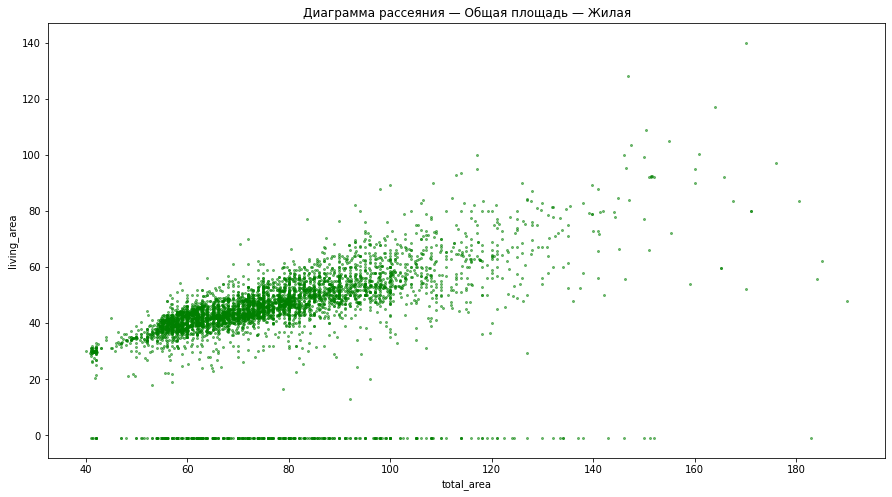

In [219]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод